# GNN GAT Explainer

The goal of this notebook is to walk through Graph Attention Network (GATs) flavor of a graph neural network (GNN). GATs operate on graphs where nodes are entities  and edges encode relations. Like other attention based networks (e.g. GPT), GATs use attention layers to learn the importance of different relationships. A standard GAT layer builds 3 attention layers: 1 for the features, and 2 for each direction of connection for a node (out, back). The standard GAT typically does not use the graph's adjacency matrix (node neighbor map) and rather uses attention + masking to learn it. There are variants that take add in attention based on the adjacency to make it easier to learn.  A GAT stacks attention layers with ELU normalizations, requiring as many layers as hops that the model is trying to learn. Because GATs learn their networks they are preferable when neighbor quality is uneven or noisy and you want the model to learn which neighbors to trust instead of averaging them uniformly, like a GCn. They’re also better when relationships are asymmetric or context-dependent, since attention can weight edges differently in each direction and based on node features. Also, GATs offer more interpretable edge-level importance scores, which is valuable in domains like biology where explaining which genes or interactions drove a prediction matters. In this notebook we'll show both a traditional GAT layer and a signed GAT layer. to show how they adapt differently 

To help display how GATs work, we'll use a representation of a gene regulatory network where we have 2 specific cell types, a set of genes that are up/down regulated, and then a label for each sample to flag if it's cancerous or not. With our GAT, the goal will be to train it to take in a set of genes and how they're regulated and then predict the cell type as the *node task*, or node level prediction and whether it's cancerous as the *graph task* or graph level prediction. This dual goal will require us to balance 2 loss functions. 


## Graph Data Prep

We'll start with a common preprocessing step. Instead of a typical tokenizer, we have to create a numerical representation of our graph by enumerating the nodes and edges. This process first starts by creating a series of "token-like" IDS for our node vocabulary. In our example that becomes the gene and cell types.  We then use integers to map the relationship of the gene and cell types. This is where our **signed graph** starts since we use `+1` edges for up-regulation and `-1` for down-regulation.   As a result we end up with the following generated:
1. **x_tokens** - a list of nodes
2. **y_node** - per-node (gene) gene cell type labels. This uses a balance of the up-regulated and down-regulated genes and flags for each sample if the gene is more common with B-cells or T-cells.  We use a `-1` here to flag cells to ignore
3. **y_graph** - per-graph (sample) cancer type label. We use `1` for cancerous and `0` for benign
4. **a_list** - the nodes in our graph that link the different cell types and genes together.  We pool all the samples together into a large block-diagonal matrix.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
benign = {
    'Tcells':{'up': ['CD3D','LCK','ZAP70'],'down': ['CD19']},
    'Bcells':{'up': ['CD19','LCK'],'down': ['CD3D','ZAP70']},
  #  'Macrophages':{'up': ['CSF1R'],'down': ['CD3D','MS4A1','CD19']},
}

cancerous = {
     'Tcells':{'up': ['ZAP70'],'down': ['CD19','CD3D','LCK']},
     'Bcells':{'up': ['CD19','CD3D'],'down': ['ZAP70','LCK']},
   # 'Macrophages':{'up': ['CSF1R'],'down': ['CD3D','MS4A1','CD19']},
}

# cancerous_2 = {
#    'Tcells':{'up': ['CD3D','ZAP70'],'down': ['CD19','LCK']},
#    'Bcells':{'up': ['CD19','LCK','CD3D'],'down': ['ZAP70']},
#    # 'Macrophages':{'up': ['CSF1R'],'down': ['CD3D','MS4A1','CD19']},
# }

# cancerous_3 = {
#     'Tcells':{'up': ['LCK'],'down': ['ZAP70','CD19','CD3D']},
#     'Bcells':{'up': ['CD19','ZAP70'],'down': ['LCK','CD3D']},
#    # 'Macrophages':{'up': ['CSF1R'],'down': ['CD3D','MS4A1','CD19']},
# }
graphs = [benign, cancerous] #, cancerous_2, cancerous_3]

In [3]:
cell_types = ['Tcells','Bcells']
genes = ['CD3D','LCK','ZAP70','CD19'] #only focused on genes present
node_order = genes + [f'CT_{ct}' for ct in cell_types]   # genes first, then CT nodes
gene_mask = torch.tensor([1,1,1,1,0,0], dtype=torch.bool)
N = len(node_order) 

In [4]:
def build_vocab(genes, cell_types):
    toks = genes + [f'CT_{ct}' for ct in cell_types]
    stoi = {t:i for i,t in enumerate(toks)}; itos = {i:t for t,i in stoi.items()}
    return stoi, itos

stoi, itos = build_vocab(genes, cell_types)
vocab_size = len(stoi)

vocab_size, stoi

(6,
 {'CD3D': 0, 'LCK': 1, 'ZAP70': 2, 'CD19': 3, 'CT_Tcells': 4, 'CT_Bcells': 5})

In [5]:
def make_graph_signed(spec):
    N = len(node_order); 
    A_signed = torch.zeros(N, N)
    def idx(n): 
        return node_order.index(n)
    def add_edge(g, ct, s):
        i, j = idx(g), idx(f"CT_{ct}")
        A_signed[i,j] = s
        A_signed[j,i] = s
    for ct in cell_types:
        for g in spec[ct].get('up', []):   
            add_edge(g, ct, +1)
        for g in spec[ct].get('down', []): 
            add_edge(g, ct, -1)
    # labels for node task (0=T, 1=B) on genes only
    y_node = torch.full((N,), -1, dtype=torch.long)
    X = torch.tensor([stoi[n] for n in node_order], dtype=torch.long)
    
    # per-gene cell-type label: 0=Tcells, 1=Bcells (prefer UP, tie-break T→B, fallback from DOWN)
    y_node = torch.full((N,), -1, dtype=torch.long)
    for g in genes:
        t_up = g in spec['Tcells'].get('up', [])
        b_up = g in spec['Bcells'].get('up', [])
        t_dn = g in spec['Tcells'].get('down', [])
        b_dn = g in spec['Bcells'].get('down', [])
        lab = None
        if t_up and not b_up: 
            lab = 0
        elif b_up and not t_up: 
            lab = 1
        elif t_up and b_up: 
            lab = 0
        else:
            if t_dn and not b_dn: 
                lab = 1
            elif b_dn and not t_dn: 
                lab = 0
        if lab is not None: 
            y_node[idx(g)] = lab
    return X, y_node, A_signed

In [6]:
x_list, y_node_list, a_list = [], [], []
for spec in graphs:
    X_i, y_i, A_i = make_graph_signed(spec)
    x_list.append(X_i); y_node_list.append(y_i); a_list.append(A_i)

x_list, y_node_list, a_list

([tensor([0, 1, 2, 3, 4, 5]), tensor([0, 1, 2, 3, 4, 5])],
 [tensor([ 0,  0,  0,  1, -1, -1]), tensor([ 1, -1,  0,  1, -1, -1])],
 [tensor([[ 0.,  0.,  0.,  0.,  1., -1.],
          [ 0.,  0.,  0.,  0.,  1.,  1.],
          [ 0.,  0.,  0.,  0.,  1., -1.],
          [ 0.,  0.,  0.,  0., -1.,  1.],
          [ 1.,  1.,  1., -1.,  0.,  0.],
          [-1.,  1., -1.,  1.,  0.,  0.]]),
  tensor([[ 0.,  0.,  0.,  0., -1.,  1.],
          [ 0.,  0.,  0.,  0., -1., -1.],
          [ 0.,  0.,  0.,  0.,  1., -1.],
          [ 0.,  0.,  0.,  0., -1.,  1.],
          [-1., -1.,  1., -1.,  0.,  0.],
          [ 1., -1., -1.,  1.,  0.,  0.]])])

**x_tokens** - a list of nodes

Notice that all nodes are present in each of our samples. 

In [7]:
x_tokens = torch.stack(x_list)
x_tokens.size(), x_tokens

(torch.Size([2, 6]),
 tensor([[0, 1, 2, 3, 4, 5],
         [0, 1, 2, 3, 4, 5]]))

**y_node** - per-node (gene) gene cell type labels. This uses a balance of the up-regulated and down-regulated genes and flags for each sample. If the gene is more commonly upregulated with B-cells we flag it as `0` and if it's more commonly up-regulated in T-cells we flag it as `1`.  This evaluation is done per sample (seen here as per row). 

The last two columns are embeddings purely for cell type so we flag them as -1 to be masked during training. 

In [8]:
y_node = torch.stack(y_node_list)
y_node.size(), y_node

(torch.Size([2, 6]),
 tensor([[ 0,  0,  0,  1, -1, -1],
         [ 1, -1,  0,  1, -1, -1]]))

**y_graph** - per-graph (sample) cancer type label. We use `1` for cancerous and `0` for benign

In [9]:
y_graph = torch.tensor([0,1])  # 0=wild, 1=cancer
y_graph.size(), y_graph

(torch.Size([2]), tensor([0, 1]))

### Data Graph

Since this is a GNN explainer, let's visualize actually how these graphs look. This is in essence the graph the model is looking at and learning how to read so that if it sees a new one, it can predict the properties we are minimizing loss on (cancerous, cell type). 

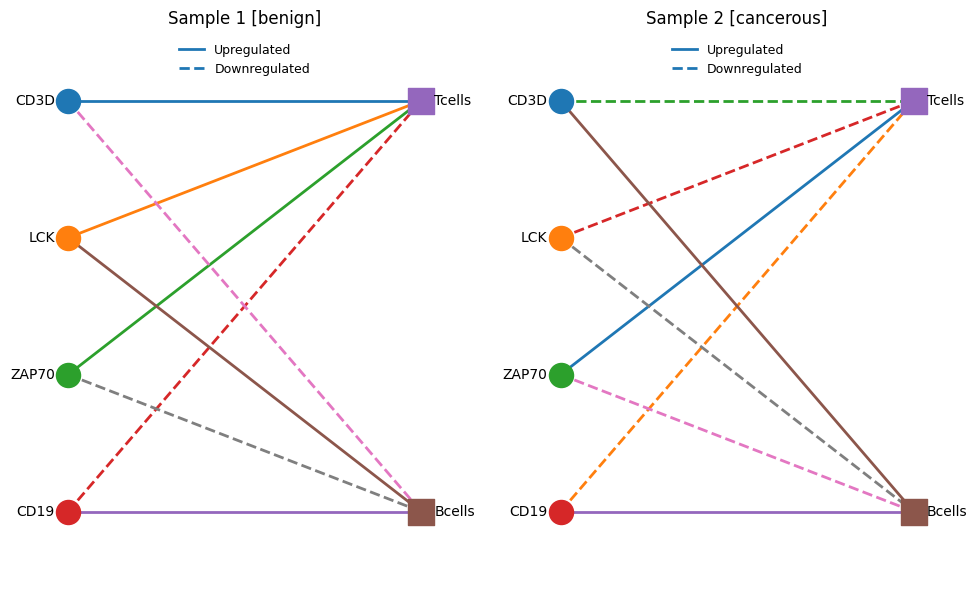

In [10]:
def compute_positions(genes, cell_types):
    # left column (genes), right column (cell types)
    gx, cx = 0.1, 0.9
    gy = list(range(len(genes)-1, -1, -1))  # top-to-bottom
    if len(cell_types) > 1:
        # spread CTs across same vertical span as genes
        span = (len(genes)-1)
        cy = [span * (1 - i/(len(cell_types)-1)) for i in range(len(cell_types))]
    else:
        cy = [(len(genes)-1)/2]
    pos = {g:(gx, gy[i]) for i,g in enumerate(genes)}
    pos.update({f"CT_{ct}":(cx, cy[j]) for j,ct in enumerate(cell_types)})
    return pos

def draw_sample(ax, spec, title, genes, cell_types):
    pos = compute_positions(genes, cell_types)
    # draw nodes
    for i,g in enumerate(genes):
        x,y = pos[g]
        ax.scatter([x],[y], s=300, marker='o', zorder=3)
        ax.text(x-0.03, y, g, va='center', ha='right', fontsize=10)
    for ct in cell_types:
        name = f"CT_{ct}"
        x,y = pos[name]
        ax.scatter([x],[y], s=350, marker='s', zorder=3)
        ax.text(x+0.03, y, ct, va='center', ha='left', fontsize=10)
    # draw edges: solid = upregulated (+1), dashed = downregulated (-1)
    for ct in cell_types:
        ct_name = f"CT_{ct}"
        for g in spec[ct].get('up', []):
            if g in genes:
                x1,y1 = pos[g]; x2,y2 = pos[ct_name]
                ax.plot([x1,x2],[y1,y2], linestyle='-', linewidth=2, zorder=2)
        for g in spec[ct].get('down', []):
            if g in genes:
                x1,y1 = pos[g]; x2,y2 = pos[ct_name]
                ax.plot([x1,x2],[y1,y2], linestyle='--', linewidth=2, zorder=2)

    # aesthetics
    ax.set_title(title)
    ax.set_xlim(0.0, 1.0)
    ys = list(range(len(genes)))
    ax.set_ylim(-0.5, len(genes)-0.5)
    ax.set_xticks([]); ax.set_yticks([])
    for spine in ax.spines.values(): spine.set_visible(False)

    # legend (solid=up, dashed=down)
    from matplotlib.lines import Line2D
    legend_lines = [
        Line2D([0],[0], linestyle='-', linewidth=2, label='Upregulated'),
        Line2D([0],[0], linestyle='--', linewidth=2, label='Downregulated'),
    ]
    ax.legend(handles=legend_lines, loc='upper center', frameon=False, fontsize=9)

# ----- draw all four samples -----
fig, axes = plt.subplots(1, 2, figsize=(10, 6))
samples = [
    ('Sample 1 [benign]',    benign),
    ('Sample 2 [cancerous]',    cancerous),
    #('Sample 3 [cancerous]',  cancerous_2),
    #('Sample 4 [cancerous]',  cancerous_3),
]
for ax, (name, spec) in zip(axes.ravel(), samples):
    draw_sample(ax, spec, name, genes, cell_types)

plt.tight_layout()
plt.show()

# Modeling

A machine learning model forward pass now uses the data prep information, runs several layers of linear algebra on it, and then "predicts" the probability of our different tasks, in this case the cell type based on the node and whether a graph is cancerous. When it is noisy (like you will see in this example), this process results in gibberish.  The training process changes the noise to pattern during the "backward pass" as you'll see. We'll show 3 steps that are focused on training:
1. **Data Loading** - this step pulls from the raw data enough examples and batches to complete a forward pass and loss calculation.  If the model is inference only, this step is replaced with taking in the inference input and preparing it similarly as the forward pass. 
2. **Forward Pass** - using the data and the model architecture we run a prediction for the tokens. When training we also compare against the expected to get loss, but in inference, we use the logits to complete the inference task.
3. **Back Propagation, aka Backward Pass & Training** - using differentials we can understand what parameters most drive the difference between forward pass' impact on its prediction versus what is actually right based on the data loading step. We compare this based on the loss function and use the partial derivative gradients to make very minor adjustments to the impactful parameters with the hope it improves future predictions.

After our back prop, we'll show a final **Forward Pass** with the updated weights we did in #3 and then convert those final weights to a **Model Inference**

## Data Loading

To start, we need to get enough data to run the forward and backward passes.  Since our total dataset in a real experiment is likely too big to be held in memory all at once in real practice, we will read just enough file information into memory so that we can run the passes, leaving memory and compute to be used on the passes instead of static data holding. 
To start, we have to identify the batch size and the model context length to determine how much data we need.  Consequently, these dimensions also form 2 of the 3 dimensions in the initial matrix.
- **Batch Size (B)** - This is the number of examples you'll train on in a single pass. 
- **Number of Nodes (N)** - This is basically the "context length" for a GNN.  This is the max number of nodes that a model can use in a pass.

Beyond these, in a GCN, the depth also controls how much context, or complexity, can be learned. This is because each GCN layer learns 1 hop, or 1 relationship of neighbors. This means that after $L$ layers, a model can learn $L$-hops worth of context.

In our case we'll set our batch to be our 4 examples, and nodes to the nodes we have configured, 6. As we walk through you'll also see our GCN will have 2 layers to model 2 network hops: gene > cell type > other genes.

We'll prepare 2 sets of data. Our **Inputs** will be the `x_token`, or our list of nodes for each example, and `a_list`, our list of node connections.  Our **Outputs** will be `y_node`, our node level cell type identification, and `y_graph`, the graph level cancerous identification. 

**x_tokens** — list of nodes for each example. Each entry is an integer token id for the node at that position in node_order (e.g.`['CD3D','LCK','ZAP70','CD19','CT_Tcells','CT_Bcells']`).  In our case you'll notice that each example contains all the nodes. 

In [11]:
B_batch, N_nodes = x_tokens.shape
B_batch, N_nodes, x_tokens

(2,
 6,
 tensor([[0, 1, 2, 3, 4, 5],
         [0, 1, 2, 3, 4, 5]]))

**y_node** - per-gene label for cell-type. `0` for T-cell marker and tie, `1` for B-cell marker. As a reminder, this is an aggregation of the up-regulated and down-regulated genes. We focus on which cell type has the gene up-regulated and, if both have it, we use 0. There are ways to handle ties better but we won't get into it.  Since `y_node` also includes the cell types, we'll use -1 to mask them as ignored.

In [12]:
y_node.size(), y_node

(torch.Size([2, 6]),
 tensor([[ 0,  0,  0,  1, -1, -1],
         [ 1, -1,  0,  1, -1, -1]]))

**y_graph** - per-graph label to determine if an example is cancerous. `0` is for benign and `1` is for cancerous.  

In [13]:
y_graph.size(), y_graph

(torch.Size([2]), tensor([0, 1]))

**a_list** - The relationships for each of our cells.  You'll notice here that only the last two rows and columns are used.  In this tensor `+1` is for **upregulated** gene per cell type and `-1` is for **downregulated**. `0` is for not in the network.  We also include here a **Gene_mask** that will act in our loss function as a flag to suppress the gene x gene portions of the matrix. 

In [14]:
gene_mask, a_list

(tensor([ True,  True,  True,  True, False, False]),
 [tensor([[ 0.,  0.,  0.,  0.,  1., -1.],
          [ 0.,  0.,  0.,  0.,  1.,  1.],
          [ 0.,  0.,  0.,  0.,  1., -1.],
          [ 0.,  0.,  0.,  0., -1.,  1.],
          [ 1.,  1.,  1., -1.,  0.,  0.],
          [-1.,  1., -1.,  1.,  0.,  0.]]),
  tensor([[ 0.,  0.,  0.,  0., -1.,  1.],
          [ 0.,  0.,  0.,  0., -1., -1.],
          [ 0.,  0.,  0.,  0.,  1., -1.],
          [ 0.,  0.,  0.,  0., -1.,  1.],
          [-1., -1.,  1., -1.,  0.,  0.],
          [ 1., -1., -1.,  1.,  0.,  0.]])])

### Data Loading - Blocked Diagonal Graph

Since we are trying to learn from all the examples in our batch, we want a uniform tensor of the network connections to learn from. We do this using a block diagonal join that creates a large tensor out of the inputs by simply sliding each new tensor to start at `[i+1,j+1]`.  In our case this results in a `[12,12]` matrix since we have 2 examples with 6 nodes. 

In [15]:
a_blk = torch.block_diag(*a_list)
a_blk.size(), a_blk

(torch.Size([12, 12]),
 tensor([[ 0.,  0.,  0.,  0.,  1., -1.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  1., -1.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0., -1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 1.,  1.,  1., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [-1.,  1., -1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  1.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1., -1.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1., -1.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  1.],
         [ 0.,  0.,  0.,  0.,  0.,  0., -1., -1.,  1., -1.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  1., -1., -1.,  1.,  0.,  0.]]))

## Forward Pass

<img src="explainer_screenshots/gat/full_network.png" width="300">

During training, in the GAT we've built, the forward pass takes in the set of nodes per example and a signed network map and uses this to predict the cell type by node and the cancerous level of the graph. This can be viewed as two different classification tasks at the head level where the head is different for each task. Here the "batch" and "token" dimensions are one in the same, being that we just have 1 dimension to signify our examples, which we'll call batch.  We could layer in batch based learning but it would make this notebook too complicated and lengthy. 

Our walkthrough of the forward pass is focused on training where we'll pass in the input nodes `x_tokens` and signed graph `a_blk`, carry that input through the layers, and generate 2 matrices of the probability for the node and graph level prediction. These predictions will be two different sets of `logits`. During the forward pass, after embedding our input nodes we'll pass through two different GAT layers to show how a signed layer and a typical layer behave and to allow the model to learn from 2 hops instead of just 1. 

At the end of the forward pass we then compare the probability in the logits to the actual next token in `y_node, y_graph` and calculate `loss` based on the difference. You'll see that we calculate the loss on each head, then sum it for a final loss (and so that we can distribute across both pathways in backprop). This difference is what we'll then use in the backprop/training steps.  

*Note that we will do some layer initialization to simplify following along.  In reality, layers are often initialized to normal distribution with some adjustments made for parameter sizes, called Xaviar Uniform, to keep the weights properly noisy.  Xaviar Uniform distributes close to 0 and  is designed so that variance of activations and gradients is preserved across layers for linear / tanh / sigmoid-style networks.  We will not cover initialization in this series*

**Attention Heads**

The beauty with attention is the use of multiple heads to allow for learning of different complex concepts.  The more complex concepts you think you want to learn, the more heads you will want to include.  This scaling allows for a broader generalization during training and usage.  

Note that the embedding channels need to be cleanly divisible into the heads to allow for flow-through. This is different than in a GPT where each attention head has the same number of channels as the embedding layer.  We're mainly doing it differently to show that both structures work, to make gradient flow easier to aid in explainability, and to reduce the footprint used. 

In [16]:
n_embd= 6
heads = 2
head_dim = n_embd // heads
depth = 1 # just a single hop
head_dim

3

### Embedding Projection

<img src="explainer_screenshots/gat/input_layer.png" width="400">

We'll first create an initial **embedding layer** for our sample level node tokens. Recall that this is the layer that will add the second dimension to our node list. We start with supplying only the nodes. In parallel our adjacency graphs will also be kept on the side as they'll be inputs to the next layer. Generally, by using an embedding on the node, we give the graph a chance to learn how important the different nodes are per example and how to use them, and the node order, in our output prediction task.  We'll also use a small embedding dimension to allow the network to learn a deeper representation of our nodes. After doing the embedding, we'll then remove our batch dimensions for the remaining training to simplify our training.  

We'll start by initializing the weight to a sliding scale so that we can quickly see each layer's impact. 

In [17]:
tok_emb = nn.Embedding(vocab_size, n_embd)
with torch.no_grad(): # initilize to W[i,j] = 0.001*(1+i+j) for easy following 
    vs, d = vocab_size, n_embd
    rows = torch.arange(vs).unsqueeze(1)  # (vs,1)
    cols = torch.arange(d).unsqueeze(0)  # (1,d)
    pattern = 0.001*(1 + rows + cols)  # W[i,j] = 0.001*(1+i+j)
    tok_emb.weight.copy_(pattern)
tok_emb.weight.size(), tok_emb.weight

(torch.Size([6, 6]),
 Parameter containing:
 tensor([[0.0010, 0.0020, 0.0030, 0.0040, 0.0050, 0.0060],
         [0.0020, 0.0030, 0.0040, 0.0050, 0.0060, 0.0070],
         [0.0030, 0.0040, 0.0050, 0.0060, 0.0070, 0.0080],
         [0.0040, 0.0050, 0.0060, 0.0070, 0.0080, 0.0090],
         [0.0050, 0.0060, 0.0070, 0.0080, 0.0090, 0.0100],
         [0.0060, 0.0070, 0.0080, 0.0090, 0.0100, 0.0110]], requires_grad=True))

**Embedding Projection**

Remember that each of our samples includes all the nodes so we expect that all the weights will be used repeatedly for each sample.  

In [18]:
x = tok_emb(x_tokens)
x.size(), x

(torch.Size([2, 6, 6]),
 tensor([[[0.0010, 0.0020, 0.0030, 0.0040, 0.0050, 0.0060],
          [0.0020, 0.0030, 0.0040, 0.0050, 0.0060, 0.0070],
          [0.0030, 0.0040, 0.0050, 0.0060, 0.0070, 0.0080],
          [0.0040, 0.0050, 0.0060, 0.0070, 0.0080, 0.0090],
          [0.0050, 0.0060, 0.0070, 0.0080, 0.0090, 0.0100],
          [0.0060, 0.0070, 0.0080, 0.0090, 0.0100, 0.0110]],
 
         [[0.0010, 0.0020, 0.0030, 0.0040, 0.0050, 0.0060],
          [0.0020, 0.0030, 0.0040, 0.0050, 0.0060, 0.0070],
          [0.0030, 0.0040, 0.0050, 0.0060, 0.0070, 0.0080],
          [0.0040, 0.0050, 0.0060, 0.0070, 0.0080, 0.0090],
          [0.0050, 0.0060, 0.0070, 0.0080, 0.0090, 0.0100],
          [0.0060, 0.0070, 0.0080, 0.0090, 0.0100, 0.0110]]],
        grad_fn=<EmbeddingBackward0>))

**Remove Batch**

Now we'll remove the batch for further training and learning. If you recall we combined our networks using blocked diagonals so the batch removal now aligns the "sample"/"node" dimension  with the dimension in the network tensor. 

In [19]:
x = x.view(B_batch*N_nodes,n_embd) # remove batch
x.size(), x

(torch.Size([12, 6]),
 tensor([[0.0010, 0.0020, 0.0030, 0.0040, 0.0050, 0.0060],
         [0.0020, 0.0030, 0.0040, 0.0050, 0.0060, 0.0070],
         [0.0030, 0.0040, 0.0050, 0.0060, 0.0070, 0.0080],
         [0.0040, 0.0050, 0.0060, 0.0070, 0.0080, 0.0090],
         [0.0050, 0.0060, 0.0070, 0.0080, 0.0090, 0.0100],
         [0.0060, 0.0070, 0.0080, 0.0090, 0.0100, 0.0110],
         [0.0010, 0.0020, 0.0030, 0.0040, 0.0050, 0.0060],
         [0.0020, 0.0030, 0.0040, 0.0050, 0.0060, 0.0070],
         [0.0030, 0.0040, 0.0050, 0.0060, 0.0070, 0.0080],
         [0.0040, 0.0050, 0.0060, 0.0070, 0.0080, 0.0090],
         [0.0050, 0.0060, 0.0070, 0.0080, 0.0090, 0.0100],
         [0.0060, 0.0070, 0.0080, 0.0090, 0.0100, 0.0110]],
        grad_fn=<ViewBackward0>))

### GAT Block

<img src="explainer_screenshots/gat/block_details.png" width="400">

To support our two hops of learning (Cell type > gene > cell type) we stack two signed graph attention layers with a nonlinearity to learn increasingly expressive node features. We have two different types of attention layers: one that includes the signed graph attention and one closer to a vanilla GAT that only has attention on the nodes. 


Each graph attention layer first projects node embeddings with a shared linear map per head, then computes edge-wise attention scores that depend on both endpoint features and, if signed, the sign of the interaction. For each head $h$, we form
$$
e_{ij}^{h}=\text{LeakyReLU}\big((a_{src}^{h})^\top W^{h}x_i + (a_{dst}^{h})^\top W^{h}x_j\big),
$$
If the GAT is signed an addition $a_{sign}^{h} s_{ij}$ is added. 

After this, we mask non-edges, and apply a softmax over neighbors $j$ to get attention weights $\alpha_{ij}^{h}$. The updated node state is then a signed, attention-weighted aggregation of neighbor “values”

$$
h_i^{\prime(h)}=\sum_j \alpha_{ij}^{h} W^{h}x_j
$$

If the GAT is signed, we also multiply by our signed edges $s_{ij}$ again. We concatenate the multi-head outputs back into a single embedding.  In this structure, the attention Query, Key, and Value can be thought of as
* $Query = (a_{src}^{h})^\top W^{h}x_i$
* $Key = (a_{dst}^{h})^\top W^{h}x_j$
* $Value = W^{h}x_j$

We apply dropout to node features and attention coefficients to regularize both representations and neighbor selection. We use an LeakyReLU nonlinearity inside each GAT and ELU between GAT to preserve informative negative signals, and add residual connections around stacked attention layers so information can bypass noisy edges, allowing deeper models that remain expressive while still respecting up vs. down regulation patterns encoded by the signed edges.

#### GAT Block - Signed First Attention Layer

<img src="explainer_screenshots/gat/signed_gat.png" width="400">

Our first GAT layer is signed so it includes the attention for the signed network to the standard GAT structure. This means that we perform the following:
$$
e_{ij}^{h}=\text{LeakyReLU}\big((a_{src}^{h})^\top W^{h}x_i + (a_{dst}^{h})^\top W^{h}x_j + a_{sign}^{h} \odot s_{ij}\big),
$$

The addition of the signed edge attention allows the model to use the known graph edges without having to learn them in the attention alone. This allows the model to learn with less data.  

For this GAT layer, we'll 
1. Run feature dropout
2. Calculate our linear projection and node attention
3. Calculate the signed edge attention
4. Run nonlinearity, masking, and softmax
5. Calculate the Hadamard product of the attention and the signed network map.
6. Take the dot product of the edge attention with the linear projection creating a learned network map.
7. A final ELU nonlinearity to support positive and negative values. 

The inclusion of the Hadamard product allows for gradients to flow down to individual elements of the network map allowing for more precise learning. 

##### Feature Dropout

We'll start with feature level dropout in the incoming embedding.  Dropout will randomly zero out any value effectively removing that specific node from impacting prediction. Since this is Bernoulli based dropout, in addition to zeroing out weights the surviving entries are scaled by $1/(1-p)$.  Feature level dropout stops the model from overfitting to very specific feature patterns and encourages robustness in the learned representations before attention even happens. You can think of it as applying the following: “don’t over-trust any single feature dimension.” 

Since this introduces `0` you can quickly see the dropout's impact on the embeddings.  You'll also see a 10% increase in the value of each row due to the normalization that dropout does. 

In [20]:
feat_dropout=0.10
gat1_fdrop = nn.Dropout(feat_dropout)

In [21]:
x_drop = gat1_fdrop(x)
x_drop.size(), x_drop

(torch.Size([12, 6]),
 tensor([[0.0011, 0.0022, 0.0033, 0.0044, 0.0056, 0.0067],
         [0.0000, 0.0033, 0.0044, 0.0056, 0.0067, 0.0078],
         [0.0033, 0.0044, 0.0056, 0.0067, 0.0078, 0.0089],
         [0.0044, 0.0056, 0.0067, 0.0000, 0.0089, 0.0100],
         [0.0056, 0.0067, 0.0078, 0.0089, 0.0100, 0.0111],
         [0.0067, 0.0078, 0.0089, 0.0000, 0.0111, 0.0122],
         [0.0011, 0.0022, 0.0033, 0.0044, 0.0056, 0.0067],
         [0.0000, 0.0033, 0.0044, 0.0000, 0.0067, 0.0078],
         [0.0000, 0.0044, 0.0056, 0.0067, 0.0078, 0.0089],
         [0.0044, 0.0056, 0.0067, 0.0078, 0.0089, 0.0100],
         [0.0056, 0.0067, 0.0078, 0.0000, 0.0100, 0.0111],
         [0.0067, 0.0078, 0.0089, 0.0100, 0.0111, 0.0000]],
        grad_fn=<MulBackward0>))

##### Per-Head Linear Projection

Our first step is to a multi-headed linear projection of the node features.  We create a separate weighted matrix per head so that each head can learn concepts independently.  This slices the embedding space into learned sub-spaces for attention to interact with. This subspace is at the node level allowing the attention to interact with different weights of each node when building connections. 

We'll initialize both heads at the same sliding weight. Because of this you'll see the two heads result in the same product and each channel scales the previous one.

In [22]:
gat1_attn_w = nn.Parameter(torch.empty(heads, n_embd, head_dim))
with torch.no_grad(): 
    vs, d = n_embd, head_dim
    rows = torch.arange(vs).unsqueeze(1)  # (vs,1)
    cols = torch.arange(d).unsqueeze(0)  # (1,d)
    pattern = 0.1*(1 + cols)  # W[i,j] = 0.001*(1+i+j)
    gat1_attn_w.copy_(pattern)
gat1_attn_w.size(), gat1_attn_w

(torch.Size([2, 6, 3]),
 Parameter containing:
 tensor([[[0.1000, 0.2000, 0.3000],
          [0.1000, 0.2000, 0.3000],
          [0.1000, 0.2000, 0.3000],
          [0.1000, 0.2000, 0.3000],
          [0.1000, 0.2000, 0.3000],
          [0.1000, 0.2000, 0.3000]],
 
         [[0.1000, 0.2000, 0.3000],
          [0.1000, 0.2000, 0.3000],
          [0.1000, 0.2000, 0.3000],
          [0.1000, 0.2000, 0.3000],
          [0.1000, 0.2000, 0.3000],
          [0.1000, 0.2000, 0.3000]]], requires_grad=True))

In [23]:
Hproj = x_drop @ gat1_attn_w
Hproj.size(), Hproj

(torch.Size([2, 12, 3]),
 tensor([[[0.0023, 0.0047, 0.0070],
          [0.0028, 0.0056, 0.0083],
          [0.0037, 0.0073, 0.0110],
          [0.0036, 0.0071, 0.0107],
          [0.0050, 0.0100, 0.0150],
          [0.0047, 0.0093, 0.0140],
          [0.0023, 0.0047, 0.0070],
          [0.0022, 0.0044, 0.0067],
          [0.0033, 0.0067, 0.0100],
          [0.0043, 0.0087, 0.0130],
          [0.0041, 0.0082, 0.0123],
          [0.0044, 0.0089, 0.0133]],
 
         [[0.0023, 0.0047, 0.0070],
          [0.0028, 0.0056, 0.0083],
          [0.0037, 0.0073, 0.0110],
          [0.0036, 0.0071, 0.0107],
          [0.0050, 0.0100, 0.0150],
          [0.0047, 0.0093, 0.0140],
          [0.0023, 0.0047, 0.0070],
          [0.0022, 0.0044, 0.0067],
          [0.0033, 0.0067, 0.0100],
          [0.0043, 0.0087, 0.0130],
          [0.0041, 0.0082, 0.0123],
          [0.0044, 0.0089, 0.0133]]], grad_fn=<CloneBackward0>))

#####  Linear Node Attention

Our linear Node attention now takes the per-head project and starts creating edge-specific weights between each pair of connected nodes. This is where our GAT layer begins to learn the adjacency importance. We still keep separation by head so that each head can learn its own relationships. For each head, it scores a builds potential edges edge $i \leftarrow j$ by applying a learned vector to the destination features (thought of as a key) and another to the source features (thought of as a value), then adding them to get a compatibility logit $e_{ij}^{h}$. These learned weights represent “how much should node $i$ listen to node $j$ for this head.” This makes neighbor influence data-driven and asymmetric: different heads can specialize to different patterns (e.g. strong T-cell–like signatures, aberrant cancer patterns), and each node can selectively amplify or suppress specific neighbors rather than averaging them uniformly.

**Source Node (Query)**

We'll start with the source first. We'll initialize the heads so that the second head is double the first.  As a result you can see that the output of this shows the second head as double the first. We will also initialize with consistent weights across the head dimension so that we can see in backprop how the model changes the importance of the different dimensions thereby building a network representation.

In [24]:
gat1_attn_src = nn.Parameter(torch.empty(heads, head_dim, 1))
with torch.no_grad(): 
    src_pattern = torch.tensor([[[0.1],[0.1],[0.1]],[[0.2],[0.2],[0.2]]])
    gat1_attn_src.copy_(src_pattern)
gat1_attn_src.size(), gat1_attn_src

(torch.Size([2, 3, 1]),
 Parameter containing:
 tensor([[[0.1000],
          [0.1000],
          [0.1000]],
 
         [[0.2000],
          [0.2000],
          [0.2000]]], requires_grad=True))

In [25]:
e_src = Hproj @ gat1_attn_src
e_src.size(), e_src

(torch.Size([2, 12, 1]),
 tensor([[[0.0014],
          [0.0017],
          [0.0022],
          [0.0021],
          [0.0030],
          [0.0028],
          [0.0014],
          [0.0013],
          [0.0020],
          [0.0026],
          [0.0025],
          [0.0027]],
 
         [[0.0028],
          [0.0033],
          [0.0044],
          [0.0043],
          [0.0060],
          [0.0056],
          [0.0028],
          [0.0027],
          [0.0040],
          [0.0052],
          [0.0049],
          [0.0053]]], grad_fn=<UnsafeViewBackward0>))

In [26]:
e_src = e_src.permute(1, 2, 0)
e_src.size(), e_src

(torch.Size([12, 1, 2]),
 tensor([[[0.0014, 0.0028]],
 
         [[0.0017, 0.0033]],
 
         [[0.0022, 0.0044]],
 
         [[0.0021, 0.0043]],
 
         [[0.0030, 0.0060]],
 
         [[0.0028, 0.0056]],
 
         [[0.0014, 0.0028]],
 
         [[0.0013, 0.0027]],
 
         [[0.0020, 0.0040]],
 
         [[0.0026, 0.0052]],
 
         [[0.0025, 0.0049]],
 
         [[0.0027, 0.0053]]], grad_fn=<PermuteBackward0>))

**Destination Node (Key)**

Next we'll build the destination attention. We'll initialize the heads so that the first head is 1.5x the second and that both heads are negative.  As a result you can see the ratio is maintained for the destination and you'll see that we get negative weights, signaling in our case downregulation being important. We are doing this to help show that both positive and negative weights are useful. 

In [27]:
gat1_attn_dst = nn.Parameter(torch.empty(heads, head_dim, 1))
with torch.no_grad(): 
    dst_pattern = torch.tensor([[[-0.3],[-0.3],[-0.3]],[[-0.2],[-0.2],[-0.2]]])
    gat1_attn_dst.copy_(dst_pattern)
gat1_attn_dst.size(), gat1_attn_dst

(torch.Size([2, 3, 1]),
 Parameter containing:
 tensor([[[-0.3000],
          [-0.3000],
          [-0.3000]],
 
         [[-0.2000],
          [-0.2000],
          [-0.2000]]], requires_grad=True))

In [28]:
e_dst = Hproj @ gat1_attn_dst
e_dst.size(), e_dst

(torch.Size([2, 12, 1]),
 tensor([[[-0.0042],
          [-0.0050],
          [-0.0066],
          [-0.0064],
          [-0.0090],
          [-0.0084],
          [-0.0042],
          [-0.0040],
          [-0.0060],
          [-0.0078],
          [-0.0074],
          [-0.0080]],
 
         [[-0.0028],
          [-0.0033],
          [-0.0044],
          [-0.0043],
          [-0.0060],
          [-0.0056],
          [-0.0028],
          [-0.0027],
          [-0.0040],
          [-0.0052],
          [-0.0049],
          [-0.0053]]], grad_fn=<UnsafeViewBackward0>))

In [29]:
e_dst = e_dst.permute(2, 1, 0)
e_dst.size(), e_dst

(torch.Size([1, 12, 2]),
 tensor([[[-0.0042, -0.0028],
          [-0.0050, -0.0033],
          [-0.0066, -0.0044],
          [-0.0064, -0.0043],
          [-0.0090, -0.0060],
          [-0.0084, -0.0056],
          [-0.0042, -0.0028],
          [-0.0040, -0.0027],
          [-0.0060, -0.0040],
          [-0.0078, -0.0052],
          [-0.0074, -0.0049],
          [-0.0080, -0.0053]]], grad_fn=<PermuteBackward0>))

**Combine Node Directions Together**

Now we'll need to combine our two attention weights together.  This combination creates `[12,12]` weights creating the dimension necessary to learn the network that we have encoded in `a_blk`.  You'll see that this matches up with the dimensions of our adjacency map which is a nice mapping and shows what these weights are attempting to learn.  

Because we used a negative destination, with scalers bigger than the source, you'll see that in most cases the values are negative.  This just means that at this current initiation state the model thinks down-regulation is very important. Also, because of how our input `x_token` and embeddings have been initiated, you'll see that we actually have a repetition of two equal `[6,12,2]`.  As we do backprop and learning, this should adjust. 

In [30]:
e = e_src + e_dst
e.size(), e

(torch.Size([12, 12, 2]),
 tensor([[[-0.0028,  0.0000],
          [-0.0036, -0.0005],
          [-0.0052, -0.0016],
          [-0.0050, -0.0015],
          [-0.0076, -0.0032],
          [-0.0070, -0.0028],
          [-0.0028,  0.0000],
          [-0.0026,  0.0001],
          [-0.0046, -0.0012],
          [-0.0064, -0.0024],
          [-0.0060, -0.0021],
          [-0.0066, -0.0025]],
 
         [[-0.0025,  0.0005],
          [-0.0033,  0.0000],
          [-0.0049, -0.0011],
          [-0.0047, -0.0009],
          [-0.0073, -0.0027],
          [-0.0067, -0.0023],
          [-0.0025,  0.0005],
          [-0.0023,  0.0007],
          [-0.0043, -0.0007],
          [-0.0061, -0.0019],
          [-0.0057, -0.0016],
          [-0.0063, -0.0020]],
 
         [[-0.0020,  0.0016],
          [-0.0028,  0.0011],
          [-0.0044,  0.0000],
          [-0.0042,  0.0001],
          [-0.0068, -0.0016],
          [-0.0062, -0.0012],
          [-0.0020,  0.0016],
          [-0.0018,  0.0017],
        

##### Signed Edge Attention

This version of our GAT includes learned attention for the signed edges.  This is non-standard for GAT but I wanted to show how you'd inject it into the Attention block.  Since we want this to be an influence on the learned network attention, we need to learn how much an edge should influence. We achieve this by using a learned scaler and the Hadamard product, or element wise product. This allows each value to be multiplied by a learned scalar.  Additionally, since we have multi-headed attention, we will need two scalares so that each head can learn independently. 

We'll start by first prepping our adjacency map.  We'll need to do 3 things:
1. We want to make sure that our adjacency allows nodes to learn self references, so we first want to fill in the diagonal with a non-0 value.  We'll use `0.5` since `1` is upregulated and `-1` is downregulated. 
2. Since we have the adjacency and are going to manipulate it, we first will extract the adjacency mask out.  This mask will be used on our network attention to break the back-propogation on node interactions that are not present in our example.  We'll cover how that's done in the masking step.
3. Extract the edges out of the adjacency and multiply them by the scalar. This will be our learned Signed Edge Attention where the model can decide how much of the edge is important to the network. 

**Prep Adjacency Map**

We'll first start by filling the diagonal and extracting a mask.  The mask will be a boolean tensor that shows all of the entries in our adjacency that are not connected.  

In [31]:
signed_a = a_blk.clone()
signed_a.fill_diagonal_(0.5)                       # self-loops are positive
mask = (signed_a == 0)  
mask = mask.unsqueeze(-1)
mask.size(), mask

(torch.Size([12, 12, 1]),
 tensor([[[False],
          [ True],
          [ True],
          [ True],
          [False],
          [False],
          [ True],
          [ True],
          [ True],
          [ True],
          [ True],
          [ True]],
 
         [[ True],
          [False],
          [ True],
          [ True],
          [False],
          [False],
          [ True],
          [ True],
          [ True],
          [ True],
          [ True],
          [ True]],
 
         [[ True],
          [ True],
          [False],
          [ True],
          [False],
          [False],
          [ True],
          [ True],
          [ True],
          [ True],
          [ True],
          [ True]],
 
         [[ True],
          [ True],
          [ True],
          [False],
          [False],
          [False],
          [ True],
          [ True],
          [ True],
          [ True],
          [ True],
          [ True]],
 
         [[False],
          [False],
          [F

In [32]:
signed_a = signed_a.unsqueeze(-1) # [M,M,1] sign tensor
signed_a.size(), signed_a

(torch.Size([12, 12, 1]),
 tensor([[[ 0.5000],
          [ 0.0000],
          [ 0.0000],
          [ 0.0000],
          [ 1.0000],
          [-1.0000],
          [ 0.0000],
          [ 0.0000],
          [ 0.0000],
          [ 0.0000],
          [ 0.0000],
          [ 0.0000]],
 
         [[ 0.0000],
          [ 0.5000],
          [ 0.0000],
          [ 0.0000],
          [ 1.0000],
          [ 1.0000],
          [ 0.0000],
          [ 0.0000],
          [ 0.0000],
          [ 0.0000],
          [ 0.0000],
          [ 0.0000]],
 
         [[ 0.0000],
          [ 0.0000],
          [ 0.5000],
          [ 0.0000],
          [ 1.0000],
          [-1.0000],
          [ 0.0000],
          [ 0.0000],
          [ 0.0000],
          [ 0.0000],
          [ 0.0000],
          [ 0.0000]],
 
         [[ 0.0000],
          [ 0.0000],
          [ 0.0000],
          [ 0.5000],
          [-1.0000],
          [ 1.0000],
          [ 0.0000],
          [ 0.0000],
          [ 0.0000],
          [ 0.0000],

**Edge Attention**

Now we'll calculate our edge attention. We'll initiate our first head to be 2x our second.  Also, because our adjacency map is simply either `[-1,0.5,1]` when it's not 0, you can see how the edge gets projected to the two heads.  

In [33]:
gat1_attn_sign = nn.Parameter(torch.zeros(1, 1, heads))
with torch.no_grad(): 
    sign_pattern = torch.tensor([[[0.2, 0.1]]])
    gat1_attn_sign.copy_(sign_pattern)
gat1_attn_sign.size(), gat1_attn_sign

(torch.Size([1, 1, 2]),
 Parameter containing:
 tensor([[[0.2000, 0.1000]]], requires_grad=True))

In [34]:
e_sig_a = signed_a * gat1_attn_sign
e_sig_a.size(), e_sig_a

(torch.Size([12, 12, 2]),
 tensor([[[ 0.1000,  0.0500],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.2000,  0.1000],
          [-0.2000, -0.1000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000]],
 
         [[ 0.0000,  0.0000],
          [ 0.1000,  0.0500],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.2000,  0.1000],
          [ 0.2000,  0.1000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000]],
 
         [[ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.1000,  0.0500],
          [ 0.0000,  0.0000],
          [ 0.2000,  0.1000],
          [-0.2000, -0.1000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
        

**Combine Node and Edge Attention**

Now to allow our edge attention to have an impact on the learned node attention, we need to combine them.  This is a simple summation of the two weights. You'll see that in some of the edges the values were pulled positive showing how impactful the signed edge attention can be when included.   

In [35]:
out = e + e_sig_a 
out.size(), out

(torch.Size([12, 12, 2]),
 tensor([[[ 9.7200e-02,  5.0000e-02],
          [-3.6000e-03, -5.3333e-04],
          [-5.2000e-03, -1.6000e-03],
          [-5.0000e-03, -1.4667e-03],
          [ 1.9240e-01,  9.6800e-02],
          [-2.0700e-01, -1.0280e-01],
          [-2.8000e-03,  0.0000e+00],
          [-2.6000e-03,  1.3333e-04],
          [-4.6000e-03, -1.2000e-03],
          [-6.4000e-03, -2.4000e-03],
          [-6.0000e-03, -2.1333e-03],
          [-6.6000e-03, -2.5333e-03]],
 
         [[-2.5333e-03,  5.3333e-04],
          [ 9.6667e-02,  5.0000e-02],
          [-4.9333e-03, -1.0667e-03],
          [-4.7333e-03, -9.3333e-04],
          [ 1.9267e-01,  9.7333e-02],
          [ 1.9327e-01,  9.7733e-02],
          [-2.5333e-03,  5.3333e-04],
          [-2.3333e-03,  6.6667e-04],
          [-4.3333e-03, -6.6667e-04],
          [-6.1333e-03, -1.8667e-03],
          [-5.7333e-03, -1.6000e-03],
          [-6.3333e-03, -2.0000e-03]],
 
         [[-2.0000e-03,  1.6000e-03],
          [-2.8000

##### Leaky ReLU

Next we apply leaky ReLU (rectified linear units), an element-wise nonlinearity that leaves positive activations unchanged and scales negative activations by a small factor, in our case `0.5`. In graph networks it is commonly used to introduce nonlinearity while preserving gradient flow through negative values and avoiding “dying units.” Additionally, leaky ReLU preserves relative ordering between moderately negative vs strongly negative scores, which still matters once you apply the softmax across neighbors. In our signed setup, it’s especially useful because negative contributions (e.g. down-regulation) don’t get hard-clipped; they remain part of the competition for attention instead of being erased outright like would be the case if using ReLU.

The formula applied is:
$$
y=\max(\alpha x,x)=
\begin{cases}
x,& x>0\\
\alpha x,& x\leq 0
\end{cases} \quad
\frac{\partial y}{\partial x}=
\begin{cases}
1,& x>0 \\
\alpha,& x\leq 0
\end{cases}
$$

LeakyReLU is stateless, meaning it has no learnable parameters.  As an output you can see that positive values remained in their state while negative values were cut in half. 

In [36]:
gat1_attn_lrelu = nn.LeakyReLU(0.5, inplace=True)
out = gat1_attn_lrelu(out)
out.size(), out

(torch.Size([12, 12, 2]),
 tensor([[[ 9.7200e-02,  5.0000e-02],
          [-1.8000e-03, -2.6667e-04],
          [-2.6000e-03, -8.0000e-04],
          [-2.5000e-03, -7.3333e-04],
          [ 1.9240e-01,  9.6800e-02],
          [-1.0350e-01, -5.1400e-02],
          [-1.4000e-03,  0.0000e+00],
          [-1.3000e-03,  1.3333e-04],
          [-2.3000e-03, -6.0000e-04],
          [-3.2000e-03, -1.2000e-03],
          [-3.0000e-03, -1.0667e-03],
          [-3.3000e-03, -1.2667e-03]],
 
         [[-1.2667e-03,  5.3333e-04],
          [ 9.6667e-02,  5.0000e-02],
          [-2.4667e-03, -5.3333e-04],
          [-2.3667e-03, -4.6667e-04],
          [ 1.9267e-01,  9.7333e-02],
          [ 1.9327e-01,  9.7733e-02],
          [-1.2667e-03,  5.3333e-04],
          [-1.1667e-03,  6.6667e-04],
          [-2.1667e-03, -3.3333e-04],
          [-3.0667e-03, -9.3333e-04],
          [-2.8667e-03, -8.0000e-04],
          [-3.1667e-03, -1.0000e-03]],
 
         [[-1.0000e-03,  1.6000e-03],
          [-1.4000

##### Masking

Our next step is to mask the edges that we know are not present in our example.  Recall that we built the boolean based mask from our adjacency map when building the signed edge attention. In this mask, a `true` value represented a connection that needed to be suppressed. 

Since this is the branch for node connections , we need to mute the weights for where there is no edge so that gradients can't flow backwards there. We'll do this in 2 steps.  First we'll replace the values with $-\infty$ and then during `softmax` those values will become 0. 

Similar to other steps, we'll need to unravel our mask to a representation of each edge and then our masked fill will apply the value across both heads. You'll see that after masking the weight sparsity significantly jumps. 

In [37]:
out = out.masked_fill(mask, float('-inf'))
out.size(), out

(torch.Size([12, 12, 2]),
 tensor([[[ 0.0972,  0.0500],
          [   -inf,    -inf],
          [   -inf,    -inf],
          [   -inf,    -inf],
          [ 0.1924,  0.0968],
          [-0.1035, -0.0514],
          [   -inf,    -inf],
          [   -inf,    -inf],
          [   -inf,    -inf],
          [   -inf,    -inf],
          [   -inf,    -inf],
          [   -inf,    -inf]],
 
         [[   -inf,    -inf],
          [ 0.0967,  0.0500],
          [   -inf,    -inf],
          [   -inf,    -inf],
          [ 0.1927,  0.0973],
          [ 0.1933,  0.0977],
          [   -inf,    -inf],
          [   -inf,    -inf],
          [   -inf,    -inf],
          [   -inf,    -inf],
          [   -inf,    -inf],
          [   -inf,    -inf]],
 
         [[   -inf,    -inf],
          [   -inf,    -inf],
          [ 0.0956,  0.0500],
          [   -inf,    -inf],
          [ 0.1932,  0.0984],
          [-0.1031, -0.0506],
          [   -inf,    -inf],
          [   -inf,    -inf],
        

##### SoftMax

Now we'll apply the softmax. The softmax turns the attention this far into a connection strength measure. In essence this encodes “how strongly each head trusts neighbors".  Softmax turns a real-valued vector into a probability distribution by exponentiating each component and normalizing by the sum so all outputs are nonnegative and sum to 1.  It does this by applying the following: 

$\frac{e^{x_i}}{\sum_{j=1}^{n} e^{x_j}}$

Because of this calculation, we can expect that the values we masked with $-\infty$ will become 0 due to their extreme negativeness, showing the power of the mask.  Also, now you'll see that each row changes in value since you have `n+1` elements in each row to distribute across. Finally, we'll now see that all of our negative values are removed.  We are not worried about that though since we'll add the sign back in. 

In [38]:
out = torch.softmax(out, dim=1)
out.size(), out

(torch.Size([12, 12, 2]),
 tensor([[[0.3427, 0.3388],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.3769, 0.3550],
          [0.2804, 0.3061],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000]],
 
         [[0.0000, 0.0000],
          [0.3123, 0.3229],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.3438, 0.3385],
          [0.3440, 0.3386],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000]],
 
         [[0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.3422, 0.3385],
          [0.0000, 0.0000],
          [0.3773, 0.3553],
          [0.2805, 0.3061],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.000

##### Attention Dropout

Now that we have our attention probabilities calculated, we'll do another round of dropout. Attention dropout is an edge-level / neighbor-level regularization. Because it randomly drops some attention coefficients during training it prevents the model from collapsing onto a single neighbor or a tiny subset of edges, forces heads to consider multiple neighbors and not overfit to one “perfect” regulatory edge and, in our signed version, it’s acts as stochastic pruning of both up- and down-regulation edges during training. The best way to think of it is “don’t over-trust any single edge/neighbor.”  Again, this is Bernoulli based dropout, in addition to zeroing out weights the surviving entries are scaled by $1/(1-p)$.  We'll use a p of 0.05 so you'll see the non-0 values increase by that scalar. 

In [39]:
attn_dropout = 0.05
gat1_attn_drop = nn.Dropout(attn_dropout)

In [40]:
out = gat1_attn_drop(out) 
out.size(), out

(torch.Size([12, 12, 2]),
 tensor([[[0.3607, 0.3566],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.3968, 0.3737],
          [0.2951, 0.3223],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000]],
 
         [[0.0000, 0.0000],
          [0.3287, 0.3398],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.3618, 0.3563],
          [0.3621, 0.3565],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000]],
 
         [[0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.3564],
          [0.0000, 0.0000],
          [0.3971, 0.3740],
          [0.2953, 0.3222],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.000

##### Sign Aware Attention

Now that we calculated the attention we'll add in our sign again. The previous softmax gave us the connection strength but now we need the direction to encode up and down regulation. By taking the Hadamard product we allow each edge to be scaled by the adjacency value making inhibitory edges contribute with a negative weight and excitatory edges with a positive weight, so the same attention pattern can either reinforce or oppose a signal depending on biology. 

We'll first start by reshaping our current weight and the adjacency map to match dimensions per head. 

In [41]:
out = out.permute(2, 0, 1) # [H,M,M]
out.size(), out

(torch.Size([2, 12, 12]),
 tensor([[[0.3607, 0.0000, 0.0000, 0.0000, 0.3968, 0.2951, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.3287, 0.0000, 0.0000, 0.3618, 0.3621, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.3971, 0.2953, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.3602, 0.2952, 0.3973, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.2270, 0.2268, 0.2264, 0.1681, 0.2044, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.1782, 0.2401, 0.1780, 0.2398, 0.0000, 0.2166, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3605, 0.0000,
           0.0000, 0.0000, 0.2951, 0.3970],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3992,
           0.0000, 0.0000, 0.3267, 0.3266],
          [0.0000, 0.0

In [42]:
s_heads = signed_a.squeeze(-1).unsqueeze(0).expand(heads, -1, -1) # [H,M,M]
s_heads.size(), s_heads

(torch.Size([2, 12, 12]),
 tensor([[[ 0.5000,  0.0000,  0.0000,  0.0000,  1.0000, -1.0000,  0.0000,
            0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.5000,  0.0000,  0.0000,  1.0000,  1.0000,  0.0000,
            0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.5000,  0.0000,  1.0000, -1.0000,  0.0000,
            0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.5000, -1.0000,  1.0000,  0.0000,
            0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 1.0000,  1.0000,  1.0000, -1.0000,  0.5000,  0.0000,  0.0000,
            0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [-1.0000,  1.0000, -1.0000,  1.0000,  0.0000,  0.5000,  0.0000,
            0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.5000,
            0.0000,  0.0000,  0.0000, -1.0000,  1.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  

**Direction Scaled Attention**

Now that we have the dimensions aligned we'll run our scaled multiple.  You'll see that the softmax weights now adopt the direction of the adjacency map and the diagonals divide in half so that they're not quite as impactful as the up-regulated edges

In [43]:
out = out * s_heads # [H,M,M]
out.size(), out

(torch.Size([2, 12, 12]),
 tensor([[[ 0.1804,  0.0000,  0.0000,  0.0000,  0.3968, -0.2951,  0.0000,
            0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.1644,  0.0000,  0.0000,  0.3618,  0.3621,  0.0000,
            0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.3971, -0.2953,  0.0000,
            0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.1801, -0.2952,  0.3973,  0.0000,
            0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.2270,  0.2268,  0.2264, -0.1681,  0.1022,  0.0000,  0.0000,
            0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [-0.1782,  0.2401, -0.1780,  0.2398,  0.0000,  0.1083,  0.0000,
            0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.1803,
            0.0000,  0.0000,  0.0000, -0.2951,  0.3970],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  

##### Message Aggregation

Now, for each head, we have to combine the neighbor features into updated node embeddings with the learned attention weights.  To do this we'll take the dot product of the the learned attention by the node projection to perform 
$$
text{out}_h[h, i, :] = \sum_j out_h[h, i, j] Hproj[h, j, :]
$$
This results in us taking a weighted sum over all neighbors’ features per node and per head. This turns attention scores into new node representations. This representation is how nodes aggregate information mostly from neighbors with high attention weights, and different heads learn different aggregation patterns over the same graph.

Despite starting out with the linear node projection being the same across heads, the different attention per head will now pull the nodes and channels to differing directions.  You can also see the value of the negative edges showing up with node projections now being negative. 

In [44]:
out = out @ Hproj # [H,M,O]
out.size(), out

(torch.Size([2, 12, 3]),
 tensor([[[ 0.0010,  0.0021,  0.0031],
          [ 0.0040,  0.0079,  0.0119],
          [ 0.0006,  0.0012,  0.0018],
          [ 0.0010,  0.0020,  0.0031],
          [ 0.0019,  0.0038,  0.0057],
          [ 0.0010,  0.0019,  0.0029],
          [ 0.0010,  0.0019,  0.0029],
          [-0.0024, -0.0047, -0.0071],
          [ 0.0009,  0.0018,  0.0028],
          [ 0.0013,  0.0027,  0.0040],
          [-0.0004, -0.0007, -0.0011],
          [ 0.0011,  0.0022,  0.0033]],
 
         [[ 0.0008,  0.0016,  0.0023],
          [ 0.0039,  0.0078,  0.0118],
          [ 0.0010,  0.0020,  0.0031],
          [ 0.0024,  0.0048,  0.0071],
          [ 0.0018,  0.0035,  0.0053],
          [ 0.0008,  0.0015,  0.0023],
          [ 0.0008,  0.0015,  0.0023],
          [-0.0025, -0.0050, -0.0074],
          [ 0.0007,  0.0014,  0.0021],
          [ 0.0011,  0.0022,  0.0033],
          [-0.0005, -0.0011, -0.0016],
          [ 0.0009,  0.0018,  0.0027]]], grad_fn=<UnsafeViewBackward0>))

##### Concatenate Heads

Now that we've calculated our node level weights, we'll collapse our heads together by concatenating them.  This concatenation allows the gradients to maintain the flow through the head while flowing forward to the next layer.

In [45]:
out = out.permute(1, 0, 2) # [M,H,O]
out.size(), out

(torch.Size([12, 2, 3]),
 tensor([[[ 0.0010,  0.0021,  0.0031],
          [ 0.0008,  0.0016,  0.0023]],
 
         [[ 0.0040,  0.0079,  0.0119],
          [ 0.0039,  0.0078,  0.0118]],
 
         [[ 0.0006,  0.0012,  0.0018],
          [ 0.0010,  0.0020,  0.0031]],
 
         [[ 0.0010,  0.0020,  0.0031],
          [ 0.0024,  0.0048,  0.0071]],
 
         [[ 0.0019,  0.0038,  0.0057],
          [ 0.0018,  0.0035,  0.0053]],
 
         [[ 0.0010,  0.0019,  0.0029],
          [ 0.0008,  0.0015,  0.0023]],
 
         [[ 0.0010,  0.0019,  0.0029],
          [ 0.0008,  0.0015,  0.0023]],
 
         [[-0.0024, -0.0047, -0.0071],
          [-0.0025, -0.0050, -0.0074]],
 
         [[ 0.0009,  0.0018,  0.0028],
          [ 0.0007,  0.0014,  0.0021]],
 
         [[ 0.0013,  0.0027,  0.0040],
          [ 0.0011,  0.0022,  0.0033]],
 
         [[-0.0004, -0.0007, -0.0011],
          [-0.0005, -0.0011, -0.0016]],
 
         [[ 0.0011,  0.0022,  0.0033],
          [ 0.0009,  0.0018,  0.0027]]], grad

In [46]:
out = out.reshape(B_batch*N_nodes, heads * head_dim)
out.size(), out

(torch.Size([12, 6]),
 tensor([[ 0.0010,  0.0021,  0.0031,  0.0008,  0.0016,  0.0023],
         [ 0.0040,  0.0079,  0.0119,  0.0039,  0.0078,  0.0118],
         [ 0.0006,  0.0012,  0.0018,  0.0010,  0.0020,  0.0031],
         [ 0.0010,  0.0020,  0.0031,  0.0024,  0.0048,  0.0071],
         [ 0.0019,  0.0038,  0.0057,  0.0018,  0.0035,  0.0053],
         [ 0.0010,  0.0019,  0.0029,  0.0008,  0.0015,  0.0023],
         [ 0.0010,  0.0019,  0.0029,  0.0008,  0.0015,  0.0023],
         [-0.0024, -0.0047, -0.0071, -0.0025, -0.0050, -0.0074],
         [ 0.0009,  0.0018,  0.0028,  0.0007,  0.0014,  0.0021],
         [ 0.0013,  0.0027,  0.0040,  0.0011,  0.0022,  0.0033],
         [-0.0004, -0.0007, -0.0011, -0.0005, -0.0011, -0.0016],
         [ 0.0011,  0.0022,  0.0033,  0.0009,  0.0018,  0.0027]],
        grad_fn=<UnsafeViewBackward0>))

##### Add Bias

Finally, the layer will add in a learned bias. The bias at the end lets each output channel learn its own baseline activation independent of the neighbor messages. Without it, every feature would be forced to be purely a weighted combination of neighbors, which can make it harder to represent simple shifts like “always on” or “always slightly suppressed” for certain dimensions. Adding the bias is a cheap way to increase expressiveness and gives the model flexibility to recenter or offset aggregated signals, especially important when stacking layers where small systematic shifts can accumulate.

In [47]:
gat1_bias = nn.Parameter(torch.zeros(heads*head_dim))
with torch.no_grad(): 
    sign_pattern = torch.tensor([1e-6])
    gat1_bias.copy_(sign_pattern)
gat1_bias.size(), gat1_bias

(torch.Size([6]),
 Parameter containing:
 tensor([1.0000e-06, 1.0000e-06, 1.0000e-06, 1.0000e-06, 1.0000e-06, 1.0000e-06],
        requires_grad=True))

In [48]:
out = out + gat1_bias
out.size(), out

(torch.Size([12, 6]),
 tensor([[ 0.0010,  0.0021,  0.0031,  0.0008,  0.0016,  0.0023],
         [ 0.0040,  0.0079,  0.0119,  0.0039,  0.0078,  0.0118],
         [ 0.0006,  0.0012,  0.0018,  0.0010,  0.0020,  0.0031],
         [ 0.0010,  0.0020,  0.0031,  0.0024,  0.0048,  0.0071],
         [ 0.0019,  0.0038,  0.0057,  0.0018,  0.0035,  0.0053],
         [ 0.0010,  0.0019,  0.0029,  0.0008,  0.0015,  0.0023],
         [ 0.0010,  0.0019,  0.0029,  0.0008,  0.0015,  0.0023],
         [-0.0024, -0.0047, -0.0071, -0.0025, -0.0050, -0.0074],
         [ 0.0009,  0.0018,  0.0028,  0.0007,  0.0014,  0.0021],
         [ 0.0013,  0.0027,  0.0040,  0.0011,  0.0022,  0.0033],
         [-0.0004, -0.0007, -0.0011, -0.0005, -0.0011, -0.0016],
         [ 0.0011,  0.0022,  0.0033,  0.0009,  0.0018,  0.0027]],
        grad_fn=<AddBackward0>))

#### GAT Block - ELU

Now we'll add in a Exponential Linear Unit (ELU) based non-linearity. ELU provides a smooth, non-saturating nonlinearity that preserves negative information which is useful in attention-based and signed-graph settings. For an input (x), ELU is defined as
$$
\mathrm{ELU}(x) =
\begin{cases}
x & x > 0\\
\alpha(\exp(x) - 1) & x \le 0
\end{cases}
$$

Unlike ReLU, which hard-clips all negative values to zero and Leaky ReLU that scales negatives, ELU maps them to bounded negative outputs in a smooth way, maintaining gradient flow and allowing the model to represent “suppressed” or inhibitory signals without erasing them. Between our GAT layer, this helps stabilize training after attention and aggregation, keeps features well-behaved around zero, and works naturally with both positive and negative contributions coming from signed edges and attention weights.

Since our values at this point are all relatively small, even the negatives don't significantly change.  If our values were more spread out we'd see a larger shift. 

In [49]:
gat_elu1 = nn.ELU()

In [50]:
out = gat_elu1(out)
out.size(), out

(torch.Size([12, 6]),
 tensor([[ 0.0010,  0.0021,  0.0031,  0.0008,  0.0016,  0.0023],
         [ 0.0040,  0.0079,  0.0119,  0.0039,  0.0078,  0.0118],
         [ 0.0006,  0.0012,  0.0018,  0.0010,  0.0020,  0.0031],
         [ 0.0010,  0.0020,  0.0031,  0.0024,  0.0048,  0.0071],
         [ 0.0019,  0.0038,  0.0057,  0.0018,  0.0035,  0.0053],
         [ 0.0010,  0.0019,  0.0029,  0.0008,  0.0015,  0.0023],
         [ 0.0010,  0.0019,  0.0029,  0.0008,  0.0015,  0.0023],
         [-0.0023, -0.0047, -0.0070, -0.0025, -0.0050, -0.0074],
         [ 0.0009,  0.0018,  0.0028,  0.0007,  0.0014,  0.0021],
         [ 0.0013,  0.0027,  0.0040,  0.0011,  0.0022,  0.0033],
         [-0.0004, -0.0007, -0.0011, -0.0005, -0.0011, -0.0016],
         [ 0.0011,  0.0022,  0.0033,  0.0009,  0.0018,  0.0027]],
        grad_fn=<EluBackward0>))

#### GAT Block - Second Attention Layer

<img src="explainer_screenshots/gat/default_gat.png" width="400">

Our second GAT layer does not use learned adjacency attention and is closer to a default GAT layer.  The only adjustment is the inclusion of a signed multiplier to account for negative edges. This means that our attention is:
$$
e_{ij}^{h}=\text{LeakyReLU}\big((a_{src}^{h})^\top W^{h}x_i + (a_{dst}^{h})^\top W^{h}x_j\big),
$$

By not including the signed edge attention this layer's attention must learn the adjacency weights without any aid. The benefit is that it allows the attention layer to decide how much to mix each neighbor via the non-negative weights via softmax. By still including the message transform we allow for the positive or negative components to be included. 

For this GAT layer, we'll have the same layers as the previous with the only exclusion being the signed edge attention. As a reminder we'll do the same regularization, dropout and other layers in the same order as this is learning the "second-hop" of the graph.  We'll still include multiple heads so that the model can learn different concepts. 

##### Feature Dropout

We'll again perform feature level dropout for the output of the ELU layer. As a reminder, this dropout will randomly zero out any value effectively removing that specific node from impacting prediction. Since this is Bernoulli based dropout, in addition to zeroing out weights the surviving entries are scaled by $1/(1-p)$.  We continue to maintain the benefits of feature level dropout  being “don’t over-trust any single feature dimension.” 

You'll again see the zeroing out of random values and a 10% increase in the value of each row due to the normalization that dropout does. 

In [51]:
# dropout on features (standard GAT)
gat2_fdrop = nn.Dropout(feat_dropout)
out_drop = gat2_fdrop(out)
out_drop.size(), out_drop

(torch.Size([12, 6]),
 tensor([[ 0.0011,  0.0023,  0.0034,  0.0009,  0.0017,  0.0026],
         [ 0.0044,  0.0088,  0.0132,  0.0044,  0.0087,  0.0131],
         [ 0.0007,  0.0014,  0.0020,  0.0011,  0.0023,  0.0000],
         [ 0.0011,  0.0023,  0.0034,  0.0026,  0.0053,  0.0079],
         [ 0.0021,  0.0042,  0.0063,  0.0020,  0.0039,  0.0059],
         [ 0.0011,  0.0021,  0.0032,  0.0008,  0.0017,  0.0025],
         [ 0.0011,  0.0022,  0.0032,  0.0008,  0.0017,  0.0025],
         [-0.0026, -0.0052, -0.0078, -0.0028, -0.0055, -0.0000],
         [ 0.0010,  0.0021,  0.0000,  0.0008,  0.0016,  0.0023],
         [ 0.0015,  0.0030,  0.0044,  0.0012,  0.0000,  0.0037],
         [-0.0004, -0.0008, -0.0012, -0.0006, -0.0012, -0.0018],
         [ 0.0012,  0.0000,  0.0036,  0.0010,  0.0020,  0.0030]],
        grad_fn=<MulBackward0>))

##### Per-Head Linear Projection

Again, the first step will be a multi-headed linear projection of the node features.  This projection is the same as in the first GAT layer where we create a separate weighted matrix per head so that each head can learn concepts independently. This slices the embedding space into learned sub-spaces for attention to interact with. 

We'll initialize both heads at the same sliding weights at 2x the scale of the first GAT layer.  You'll see that because we initialize the heads with the same values, the output of this layer is the same for both heads and the channels scale by 2x. 

In [52]:
gat2_attn_w = nn.Parameter(torch.empty(heads, n_embd, head_dim))
with torch.no_grad(): 
    vs, d = n_embd, head_dim
    rows = torch.arange(vs).unsqueeze(1)  # (vs,1)
    cols = torch.arange(d).unsqueeze(0)  # (1,d)
    pattern = 0.2*(1 + cols)  # W[i,j] = 0.001*(1+i+j)
    gat2_attn_w.copy_(pattern)
gat2_attn_w.size(), gat2_attn_w

(torch.Size([2, 6, 3]),
 Parameter containing:
 tensor([[[0.2000, 0.4000, 0.6000],
          [0.2000, 0.4000, 0.6000],
          [0.2000, 0.4000, 0.6000],
          [0.2000, 0.4000, 0.6000],
          [0.2000, 0.4000, 0.6000],
          [0.2000, 0.4000, 0.6000]],
 
         [[0.2000, 0.4000, 0.6000],
          [0.2000, 0.4000, 0.6000],
          [0.2000, 0.4000, 0.6000],
          [0.2000, 0.4000, 0.6000],
          [0.2000, 0.4000, 0.6000],
          [0.2000, 0.4000, 0.6000]]], requires_grad=True))

In [53]:
Hproj = out_drop @ gat2_attn_w
Hproj.size(), Hproj


(torch.Size([2, 12, 3]),
 tensor([[[ 0.0024,  0.0048,  0.0072],
          [ 0.0105,  0.0210,  0.0315],
          [ 0.0015,  0.0030,  0.0045],
          [ 0.0045,  0.0091,  0.0136],
          [ 0.0049,  0.0098,  0.0147],
          [ 0.0023,  0.0046,  0.0069],
          [ 0.0023,  0.0046,  0.0069],
          [-0.0048, -0.0096, -0.0143],
          [ 0.0015,  0.0031,  0.0046],
          [ 0.0028,  0.0055,  0.0083],
          [-0.0012, -0.0024, -0.0036],
          [ 0.0022,  0.0043,  0.0065]],
 
         [[ 0.0024,  0.0048,  0.0072],
          [ 0.0105,  0.0210,  0.0315],
          [ 0.0015,  0.0030,  0.0045],
          [ 0.0045,  0.0091,  0.0136],
          [ 0.0049,  0.0098,  0.0147],
          [ 0.0023,  0.0046,  0.0069],
          [ 0.0023,  0.0046,  0.0069],
          [-0.0048, -0.0096, -0.0143],
          [ 0.0015,  0.0031,  0.0046],
          [ 0.0028,  0.0055,  0.0083],
          [-0.0012, -0.0024, -0.0036],
          [ 0.0022,  0.0043,  0.0065]]], grad_fn=<CloneBackward0>))

#####  Linear Node Attention

We'll again build out the linear node attention. This attention takes the per-head project and starts creating edge-specific weights between each pair of connected nodes. This is where our GAT layer begins to learn the adjacency importance. We still keep separation by head so that each head can learn its own relationships. This performs the same calculation that we did for linear node attention in the first GAT layer. As a reminder, these learned weights represent “how much should node $i$ listen to node $j$ for this head.” This makes neighbor influence data-driven and asymmetric: different heads can specialize to different patterns (e.g. strong T-cell–like signatures, aberrant cancer patterns), and each node can selectively amplify or suppress specific neighbors rather than averaging them uniformly.

The biggest difference is that this will be the only network attention we'll learn in this layer so it will have to do more of the heavy lifting. 

**Source Node (Query)**

We'll again start with the source first. We'll initialize the heads so that the first head is triple the first.  As a result you can see that the output of this shows the first head as triple the second. We will also initialize with consistent weights across the head dimension so that we can see in backprop how the model changes the importance of the different dimensions thereby building a network representation.

In [54]:
gat2_attn_src = nn.Parameter(torch.empty(heads, head_dim, 1))
with torch.no_grad(): 
    src_pattern = torch.tensor([[[0.3],[0.3],[0.3]],[[0.1],[0.1],[0.1]]])
    gat2_attn_src.copy_(src_pattern)
gat2_attn_src.size(), gat2_attn_src

(torch.Size([2, 3, 1]),
 Parameter containing:
 tensor([[[0.3000],
          [0.3000],
          [0.3000]],
 
         [[0.1000],
          [0.1000],
          [0.1000]]], requires_grad=True))

In [55]:
e_src = Hproj @ gat2_attn_src
e_src.size(), e_src

(torch.Size([2, 12, 1]),
 tensor([[[ 0.0043],
          [ 0.0189],
          [ 0.0027],
          [ 0.0082],
          [ 0.0088],
          [ 0.0041],
          [ 0.0041],
          [-0.0086],
          [ 0.0028],
          [ 0.0050],
          [-0.0022],
          [ 0.0039]],
 
         [[ 0.0014],
          [ 0.0063],
          [ 0.0009],
          [ 0.0027],
          [ 0.0029],
          [ 0.0014],
          [ 0.0014],
          [-0.0029],
          [ 0.0009],
          [ 0.0017],
          [-0.0007],
          [ 0.0013]]], grad_fn=<UnsafeViewBackward0>))

In [56]:
e_src = e_src.permute(1, 2, 0)  # [M,1,H]
e_src.size(), e_src


(torch.Size([12, 1, 2]),
 tensor([[[ 0.0043,  0.0014]],
 
         [[ 0.0189,  0.0063]],
 
         [[ 0.0027,  0.0009]],
 
         [[ 0.0082,  0.0027]],
 
         [[ 0.0088,  0.0029]],
 
         [[ 0.0041,  0.0014]],
 
         [[ 0.0041,  0.0014]],
 
         [[-0.0086, -0.0029]],
 
         [[ 0.0028,  0.0009]],
 
         [[ 0.0050,  0.0017]],
 
         [[-0.0022, -0.0007]],
 
         [[ 0.0039,  0.0013]]], grad_fn=<PermuteBackward0>))

**Destination Node (Key)**

Next we'll again build the destination attention. We'll initialize the heads so that the second head is 2x the first and that both heads are positive.  As a result you can see the ratio is maintained for the destination.

In [57]:
gat2_attn_dst = nn.Parameter(torch.empty(heads, head_dim, 1))
with torch.no_grad(): 
    dst_pattern = torch.tensor([[[0.1],[0.1],[0.1]],[[0.2],[0.2],[0.2]]])
    gat2_attn_dst.copy_(dst_pattern)
gat2_attn_dst.size(), gat2_attn_dst

(torch.Size([2, 3, 1]),
 Parameter containing:
 tensor([[[0.1000],
          [0.1000],
          [0.1000]],
 
         [[0.2000],
          [0.2000],
          [0.2000]]], requires_grad=True))

In [58]:
e_dst = Hproj @ gat2_attn_dst
e_dst.size(), e_dst

(torch.Size([2, 12, 1]),
 tensor([[[ 0.0014],
          [ 0.0063],
          [ 0.0009],
          [ 0.0027],
          [ 0.0029],
          [ 0.0014],
          [ 0.0014],
          [-0.0029],
          [ 0.0009],
          [ 0.0017],
          [-0.0007],
          [ 0.0013]],
 
         [[ 0.0029],
          [ 0.0126],
          [ 0.0018],
          [ 0.0054],
          [ 0.0059],
          [ 0.0028],
          [ 0.0028],
          [-0.0057],
          [ 0.0019],
          [ 0.0033],
          [-0.0014],
          [ 0.0026]]], grad_fn=<UnsafeViewBackward0>))

In [59]:
e_dst = e_dst.permute(2, 1, 0)
e_dst.size(), e_dst

(torch.Size([1, 12, 2]),
 tensor([[[ 0.0014,  0.0029],
          [ 0.0063,  0.0126],
          [ 0.0009,  0.0018],
          [ 0.0027,  0.0054],
          [ 0.0029,  0.0059],
          [ 0.0014,  0.0028],
          [ 0.0014,  0.0028],
          [-0.0029, -0.0057],
          [ 0.0009,  0.0019],
          [ 0.0017,  0.0033],
          [-0.0007, -0.0014],
          [ 0.0013,  0.0026]]], grad_fn=<PermuteBackward0>))

**Combine Node Directions Together**

Again we'll combine our two attention weights together.  This combination creates `[12,12]` weights creating the dimension necessary to learn the network that we have encoded in `a_blk`.  You'll see that this matches up with the dimensions of our adjacency map which is a nice mapping and shows what these weights are attempting to learn.  

Because we used positive weights for both source and destination, with scalers bigger than the source, you'll see that the weights are additive and many negatives are removed.  This is not a worry since we'll add in direction after the softmax. Also, because of how our input `x_token` and embeddings have been initiated, you'll see that we actually have a repetition of two equal `[6,12,2]`.  As we do backprop and learning, this should adjust. 

In [60]:
out = e_src + e_dst            # [M,M,H
out.size(), out

(torch.Size([12, 12, 2]),
 tensor([[[ 5.7896e-03,  4.3422e-03],
          [ 1.0641e-02,  1.4045e-02],
          [ 5.2368e-03,  3.2366e-03],
          [ 7.0614e-03,  6.8858e-03],
          [ 7.2831e-03,  7.3292e-03],
          [ 5.7196e-03,  4.2021e-03],
          [ 5.7224e-03,  4.2078e-03],
          [ 1.4760e-03, -4.2851e-03],
          [ 5.2721e-03,  3.3072e-03],
          [ 6.0006e-03,  4.7641e-03],
          [ 3.6181e-03, -8.9093e-07],
          [ 5.6448e-03,  4.0526e-03]],
 
         [[ 2.0344e-02,  9.1936e-03],
          [ 2.5195e-02,  1.8896e-02],
          [ 1.9791e-02,  8.0881e-03],
          [ 2.1616e-02,  1.1737e-02],
          [ 2.1837e-02,  1.2181e-02],
          [ 2.0274e-02,  9.0535e-03],
          [ 2.0277e-02,  9.0592e-03],
          [ 1.6030e-02,  5.6629e-04],
          [ 1.9826e-02,  8.1586e-03],
          [ 2.0555e-02,  9.6155e-03],
          [ 1.8172e-02,  4.8505e-03],
          [ 2.0199e-02,  8.9040e-03]],
 
         [[ 4.1313e-03,  3.7894e-03],
          [ 8.9827

##### Leaky ReLU

Next we again apply leaky ReLU (rectified linear units), an element-wise nonlinearity that leaves positive activations unchanged and scales negative activations by a small factor, in our case `0.5`. In graph networks it is commonly used to introduce nonlinearity while preserving gradient flow through negative values and avoiding “dying units.” Additionally, leaky ReLU preserves relative ordering between moderately negative vs strongly negative scores, which still matters once you apply the softmax across neighbors. We apply the same formula as in the first GAT layer. 

As a reminder, Leaky ReLU is stateless, meaning it has no learnable parameters.  As an output you can see that positive values remained in their state while negative values were cut in half. 

In [61]:
##### regularization
gat2_attn_lrelu = nn.LeakyReLU(0.5, inplace=True)
out = gat2_attn_lrelu(out)
out.size(), out

(torch.Size([12, 12, 2]),
 tensor([[[ 5.7896e-03,  4.3422e-03],
          [ 1.0641e-02,  1.4045e-02],
          [ 5.2368e-03,  3.2366e-03],
          [ 7.0614e-03,  6.8858e-03],
          [ 7.2831e-03,  7.3292e-03],
          [ 5.7196e-03,  4.2021e-03],
          [ 5.7224e-03,  4.2078e-03],
          [ 1.4760e-03, -2.1426e-03],
          [ 5.2721e-03,  3.3072e-03],
          [ 6.0006e-03,  4.7641e-03],
          [ 3.6181e-03, -4.4546e-07],
          [ 5.6448e-03,  4.0526e-03]],
 
         [[ 2.0344e-02,  9.1936e-03],
          [ 2.5195e-02,  1.8896e-02],
          [ 1.9791e-02,  8.0881e-03],
          [ 2.1616e-02,  1.1737e-02],
          [ 2.1837e-02,  1.2181e-02],
          [ 2.0274e-02,  9.0535e-03],
          [ 2.0277e-02,  9.0592e-03],
          [ 1.6030e-02,  5.6629e-04],
          [ 1.9826e-02,  8.1586e-03],
          [ 2.0555e-02,  9.6155e-03],
          [ 1.8172e-02,  4.8505e-03],
          [ 2.0199e-02,  8.9040e-03]],
 
         [[ 4.1313e-03,  3.7894e-03],
          [ 8.9827

##### Masking

Next, we'll do masking again.  Since we did not do signed edge attention we first have to build or mask. In this mask, a `true` value represented a connection that needed to be suppressed. 

Since this is the branch for learning node connections, we need to mute the weights for where there is no edge so that gradients can't flow backwards there. We'll do this in 2 steps.  First we'll replace the values with $-\infty$ and then during `softmax` those values will become 0. 

Similar to other steps, we'll need to unravel our mask to a representation of each edge and then our masked fill will apply the value across both heads. You'll see that after masking the weight sparsity significantly jumps. 

In [62]:
signed_a = a_blk.clone()
signed_a.fill_diagonal_(0.5)                       # self-loops are positive
mask = (signed_a == 0)  
mask = mask.unsqueeze(-1)
mask.size(), mask


(torch.Size([12, 12, 1]),
 tensor([[[False],
          [ True],
          [ True],
          [ True],
          [False],
          [False],
          [ True],
          [ True],
          [ True],
          [ True],
          [ True],
          [ True]],
 
         [[ True],
          [False],
          [ True],
          [ True],
          [False],
          [False],
          [ True],
          [ True],
          [ True],
          [ True],
          [ True],
          [ True]],
 
         [[ True],
          [ True],
          [False],
          [ True],
          [False],
          [False],
          [ True],
          [ True],
          [ True],
          [ True],
          [ True],
          [ True]],
 
         [[ True],
          [ True],
          [ True],
          [False],
          [False],
          [False],
          [ True],
          [ True],
          [ True],
          [ True],
          [ True],
          [ True]],
 
         [[False],
          [False],
          [F

In [63]:
out = out.masked_fill(mask, float('-inf'))
out.size(), out

(torch.Size([12, 12, 2]),
 tensor([[[ 5.7896e-03,  4.3422e-03],
          [       -inf,        -inf],
          [       -inf,        -inf],
          [       -inf,        -inf],
          [ 7.2831e-03,  7.3292e-03],
          [ 5.7196e-03,  4.2021e-03],
          [       -inf,        -inf],
          [       -inf,        -inf],
          [       -inf,        -inf],
          [       -inf,        -inf],
          [       -inf,        -inf],
          [       -inf,        -inf]],
 
         [[       -inf,        -inf],
          [ 2.5195e-02,  1.8896e-02],
          [       -inf,        -inf],
          [       -inf,        -inf],
          [ 2.1837e-02,  1.2181e-02],
          [ 2.0274e-02,  9.0535e-03],
          [       -inf,        -inf],
          [       -inf,        -inf],
          [       -inf,        -inf],
          [       -inf,        -inf],
          [       -inf,        -inf],
          [       -inf,        -inf]],
 
         [[       -inf,        -inf],
          [       

##### SoftMax

Now we'll apply the softmax. The softmax turns the attention output into a connection strength measure. In essence this encodes “how strongly each head trusts neighbors".  Softmax turns a real-valued vector into a probability distribution by exponentiating each component and normalizing by the sum so all outputs are nonnegative and sum to 1. Similar to the first GAT layer, we again apply the following: 

$\frac{e^{x_i}}{\sum_{j=1}^{n} e^{x_j}}$

Similar to the first GAT layer, you'll see that  $-\infty$ becomes 0 and negatives become positive.

In [64]:
out = torch.softmax(out, dim=1)
out.size(), out

(torch.Size([12, 12, 2]),
 tensor([[[0.3332, 0.3330],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.3337, 0.3340],
          [0.3332, 0.3330],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000]],
 
         [[0.0000, 0.0000],
          [0.3343, 0.3352],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.3331, 0.3329],
          [0.3326, 0.3319],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000]],
 
         [[0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.3331, 0.3328],
          [0.0000, 0.0000],
          [0.3337, 0.3341],
          [0.3332, 0.3331],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.000

##### Attention Dropout

We'll run another round of attention dropout. As a reminder, attention dropout is an edge-level / neighbor-level regularization. This dropout reinforces “don’t over-trust any single edge/neighbor.”  

Again, this is Bernoulli based dropout, in addition to zeroing out weights the surviving entries are scaled by $1/(1-p)$.  We'll use a p of 0.05 so you'll see the non-0 values increase by that scalar. 

In [65]:
gat2_attn_drop = nn.Dropout(attn_dropout)
out = gat2_attn_drop(out) 
out.size(), out

(torch.Size([12, 12, 2]),
 tensor([[[0.3507, 0.3505],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.3512, 0.3516],
          [0.3507, 0.3505],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000]],
 
         [[0.0000, 0.0000],
          [0.3518, 0.3528],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.3507, 0.3505],
          [0.3501, 0.3494],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000]],
 
         [[0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.3506, 0.0000],
          [0.0000, 0.0000],
          [0.3513, 0.3517],
          [0.3508, 0.3506],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.000

##### Sign Aware Attention

Now that we calculated the attention we'll add back in the edge sign. The previous softmax gave us the connection strength but now we need the direction to encode up and down regulation. By taking the Hadamard product we allow each edge to be scaled by the adjacency value making inhibitory edges contribute with a negative weight and excitatory edges with a positive weight, so the same attention pattern can either reinforce or oppose a signal depending on biology. 

We'll first start by reshaping our current weight and the adjacency map to match dimensions per head. 

In [66]:
out = out.permute(2, 0, 1) # [H,M,M]
out.size(), out

(torch.Size([2, 12, 12]),
 tensor([[[0.3507, 0.0000, 0.0000, 0.0000, 0.3512, 0.3507, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.3518, 0.0000, 0.0000, 0.3507, 0.3501, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.3506, 0.0000, 0.3513, 0.3508, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.3510, 0.3511, 0.3505, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.2102, 0.2113, 0.2101, 0.2105, 0.2105, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.2103, 0.2113, 0.2102, 0.2106, 0.0000, 0.2103, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3511, 0.0000,
           0.0000, 0.0000, 0.3504, 0.3511],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3505,
           0.0000, 0.0000, 0.0000, 0.3512],
          [0.0000, 0.0

In [67]:
s_heads = signed_a.squeeze(-1).unsqueeze(0).expand(heads, -1, -1) # [H,M,M]
s_heads.size(), s_heads

(torch.Size([2, 12, 12]),
 tensor([[[ 0.5000,  0.0000,  0.0000,  0.0000,  1.0000, -1.0000,  0.0000,
            0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.5000,  0.0000,  0.0000,  1.0000,  1.0000,  0.0000,
            0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.5000,  0.0000,  1.0000, -1.0000,  0.0000,
            0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.5000, -1.0000,  1.0000,  0.0000,
            0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 1.0000,  1.0000,  1.0000, -1.0000,  0.5000,  0.0000,  0.0000,
            0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [-1.0000,  1.0000, -1.0000,  1.0000,  0.0000,  0.5000,  0.0000,
            0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.5000,
            0.0000,  0.0000,  0.0000, -1.0000,  1.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  

**Direction Scaled Attention**

Now that we have the dimensions aligned we'll run our scaled multiple.  You'll see that the softmax weights now adopt the direction of the adjacency map and the diagonals divide in half so that they're not quite as impactful as the up-regulated edges

In [68]:
out = out * s_heads # [H,M,M]
out.size(), out

(torch.Size([2, 12, 12]),
 tensor([[[ 0.1754,  0.0000,  0.0000,  0.0000,  0.3512, -0.3507,  0.0000,
            0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.1759,  0.0000,  0.0000,  0.3507,  0.3501,  0.0000,
            0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.1753,  0.0000,  0.3513, -0.3508,  0.0000,
            0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.1755, -0.3511,  0.3505,  0.0000,
            0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.2102,  0.2113,  0.2101, -0.2105,  0.1053,  0.0000,  0.0000,
            0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [-0.2103,  0.2113, -0.2102,  0.2106,  0.0000,  0.1051,  0.0000,
            0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.1756,
            0.0000,  0.0000,  0.0000, -0.3504,  0.3511],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  

##### Message Aggregation

Now, for each head, we have to combine the neighbor features into updated node embeddings with the learned attention weights.  As a reminder we'll take the dot product of the the learned attention by the node projection to perform 
$$
text{out}_h[h, i, :] = \sum_j out_h[h, i, j] Hproj[h, j, :]
$$

This results in us taking a weighted sum over all neighbors’ features per node and per head. This turns attention scores into new node representations. This representation is how nodes aggregate information mostly from neighbors with high attention weights, and different heads learn different aggregation patterns over the same graph.

You'll again see that we end up with different values per head because the attention per head now pulls the nodes and channels of the linear embeddings to differing directions.  You can also see the value of the negative edges showing up with node projections now being negative. 

In [69]:
out = out @ Hproj # [H,M,O]
out.size(), out

(torch.Size([2, 12, 3]),
 tensor([[[ 0.0013,  0.0027,  0.0040],
          [ 0.0044,  0.0087,  0.0131],
          [ 0.0012,  0.0024,  0.0035],
          [-0.0001, -0.0002, -0.0004],
          [ 0.0026,  0.0052,  0.0078],
          [ 0.0026,  0.0052,  0.0078],
          [ 0.0016,  0.0032,  0.0048],
          [-0.0016, -0.0032, -0.0048],
          [-0.0009, -0.0018, -0.0027],
          [ 0.0017,  0.0033,  0.0050],
          [ 0.0003,  0.0005,  0.0008],
          [ 0.0020,  0.0039,  0.0059]],
 
         [[ 0.0013,  0.0027,  0.0040],
          [ 0.0044,  0.0087,  0.0131],
          [ 0.0009,  0.0018,  0.0028],
          [-0.0001, -0.0002, -0.0004],
          [ 0.0036,  0.0071,  0.0107],
          [ 0.0026,  0.0052,  0.0078],
          [ 0.0012,  0.0023,  0.0035],
          [-0.0004, -0.0008, -0.0012],
          [-0.0009, -0.0018, -0.0027],
          [ 0.0017,  0.0033,  0.0050],
          [ 0.0001,  0.0003,  0.0004],
          [ 0.0020,  0.0039,  0.0059]]], grad_fn=<UnsafeViewBackward0>))

##### Concatenate Heads

Now that we've calculated our node level weights, we'll collapse our heads together by concatenating them.  This concatenation allows the gradients to maintain the flow through the head while flowing forward to the next layer. 

In [70]:
out = out.permute(1, 0, 2) # [M,H,O]
out.size(), out


(torch.Size([12, 2, 3]),
 tensor([[[ 0.0013,  0.0027,  0.0040],
          [ 0.0013,  0.0027,  0.0040]],
 
         [[ 0.0044,  0.0087,  0.0131],
          [ 0.0044,  0.0087,  0.0131]],
 
         [[ 0.0012,  0.0024,  0.0035],
          [ 0.0009,  0.0018,  0.0028]],
 
         [[-0.0001, -0.0002, -0.0004],
          [-0.0001, -0.0002, -0.0004]],
 
         [[ 0.0026,  0.0052,  0.0078],
          [ 0.0036,  0.0071,  0.0107]],
 
         [[ 0.0026,  0.0052,  0.0078],
          [ 0.0026,  0.0052,  0.0078]],
 
         [[ 0.0016,  0.0032,  0.0048],
          [ 0.0012,  0.0023,  0.0035]],
 
         [[-0.0016, -0.0032, -0.0048],
          [-0.0004, -0.0008, -0.0012]],
 
         [[-0.0009, -0.0018, -0.0027],
          [-0.0009, -0.0018, -0.0027]],
 
         [[ 0.0017,  0.0033,  0.0050],
          [ 0.0017,  0.0033,  0.0050]],
 
         [[ 0.0003,  0.0005,  0.0008],
          [ 0.0001,  0.0003,  0.0004]],
 
         [[ 0.0020,  0.0039,  0.0059],
          [ 0.0020,  0.0039,  0.0059]]], grad

In [71]:
out = out.reshape(B_batch*N_nodes, heads * head_dim)
out.size(), out

(torch.Size([12, 6]),
 tensor([[ 0.0013,  0.0027,  0.0040,  0.0013,  0.0027,  0.0040],
         [ 0.0044,  0.0087,  0.0131,  0.0044,  0.0087,  0.0131],
         [ 0.0012,  0.0024,  0.0035,  0.0009,  0.0018,  0.0028],
         [-0.0001, -0.0002, -0.0004, -0.0001, -0.0002, -0.0004],
         [ 0.0026,  0.0052,  0.0078,  0.0036,  0.0071,  0.0107],
         [ 0.0026,  0.0052,  0.0078,  0.0026,  0.0052,  0.0078],
         [ 0.0016,  0.0032,  0.0048,  0.0012,  0.0023,  0.0035],
         [-0.0016, -0.0032, -0.0048, -0.0004, -0.0008, -0.0012],
         [-0.0009, -0.0018, -0.0027, -0.0009, -0.0018, -0.0027],
         [ 0.0017,  0.0033,  0.0050,  0.0017,  0.0033,  0.0050],
         [ 0.0003,  0.0005,  0.0008,  0.0001,  0.0003,  0.0004],
         [ 0.0020,  0.0039,  0.0059,  0.0020,  0.0039,  0.0059]],
        grad_fn=<UnsafeViewBackward0>))

##### Add Bias

Finally we again add bias.  This bias gives this GAT layer a similar benefit that lets each output channel learn its own baseline activation independent of the neighbor messages. 

In [72]:
##### Bias
gat2_bias = nn.Parameter(torch.zeros(heads*head_dim))
with torch.no_grad(): 
    sign_pattern = torch.tensor([1e-6])
    gat2_bias.copy_(sign_pattern)
gat2_bias.size(), gat2_bias

(torch.Size([6]),
 Parameter containing:
 tensor([1.0000e-06, 1.0000e-06, 1.0000e-06, 1.0000e-06, 1.0000e-06, 1.0000e-06],
        requires_grad=True))

In [73]:
out = out + gat2_bias
out.size(), out


(torch.Size([12, 6]),
 tensor([[ 0.0013,  0.0027,  0.0040,  0.0013,  0.0027,  0.0040],
         [ 0.0044,  0.0087,  0.0131,  0.0044,  0.0087,  0.0131],
         [ 0.0012,  0.0024,  0.0035,  0.0009,  0.0018,  0.0028],
         [-0.0001, -0.0002, -0.0004, -0.0001, -0.0002, -0.0004],
         [ 0.0026,  0.0052,  0.0078,  0.0036,  0.0071,  0.0107],
         [ 0.0026,  0.0052,  0.0078,  0.0026,  0.0052,  0.0078],
         [ 0.0016,  0.0032,  0.0048,  0.0012,  0.0023,  0.0035],
         [-0.0016, -0.0032, -0.0048, -0.0004, -0.0008, -0.0012],
         [-0.0009, -0.0018, -0.0027, -0.0009, -0.0018, -0.0027],
         [ 0.0017,  0.0033,  0.0050,  0.0017,  0.0033,  0.0050],
         [ 0.0003,  0.0005,  0.0008,  0.0001,  0.0003,  0.0004],
         [ 0.0020,  0.0039,  0.0059,  0.0020,  0.0039,  0.0059]],
        grad_fn=<AddBackward0>))

### GAT Block - Residual Connection

In GATs, residual connections create a clean path for each node’s own features and gradients to combat dead/vanishing gradients that can come from the attention layers and makes deeper message-passing stacks trainable. The residual connection also counters oversmoothing by re-injecting the identity at every layer so the node embeddings are less likely to collapse toward a common subspace, especially under strong degree normalization. Functionally this is represented as

$y = f(x) + x$

To achieve this we simply sum the projection matrix `x` with the convolution layer outputs `out`.  As a reminder our input embedding was initiated using a sliding scale per channel and node. 

In [74]:
out = out + x
out.size(), out

(torch.Size([12, 6]),
 tensor([[ 0.0023,  0.0047,  0.0070,  0.0053,  0.0077,  0.0100],
         [ 0.0064,  0.0117,  0.0171,  0.0094,  0.0147,  0.0201],
         [ 0.0042,  0.0064,  0.0085,  0.0069,  0.0088,  0.0108],
         [ 0.0039,  0.0048,  0.0056,  0.0069,  0.0078,  0.0086],
         [ 0.0076,  0.0112,  0.0148,  0.0116,  0.0161,  0.0207],
         [ 0.0086,  0.0122,  0.0158,  0.0116,  0.0152,  0.0188],
         [ 0.0026,  0.0052,  0.0078,  0.0052,  0.0073,  0.0095],
         [ 0.0004, -0.0002, -0.0008,  0.0046,  0.0052,  0.0058],
         [ 0.0021,  0.0022,  0.0023,  0.0051,  0.0052,  0.0053],
         [ 0.0057,  0.0083,  0.0110,  0.0087,  0.0113,  0.0140],
         [ 0.0053,  0.0065,  0.0078,  0.0081,  0.0093,  0.0104],
         [ 0.0080,  0.0109,  0.0139,  0.0110,  0.0139,  0.0169]],
        grad_fn=<AddBackward0>))

### GAT Block - Post Residual ELU

Now we'll run another round of Exponential Linear Unit (ELU) based non-linearity. As a reminder, ELU provides a smooth, non-saturating nonlinearity that preserves negative information which is useful in attention-based and signed-graph settings. 

Since our values got pushed positive in the residual connection we shouldn't expect changes in values. 

In [75]:
elu2 = nn.ELU()
out = elu2(out)
out.size(), out

(torch.Size([12, 6]),
 tensor([[ 0.0023,  0.0047,  0.0070,  0.0053,  0.0077,  0.0100],
         [ 0.0064,  0.0117,  0.0171,  0.0094,  0.0147,  0.0201],
         [ 0.0042,  0.0064,  0.0085,  0.0069,  0.0088,  0.0108],
         [ 0.0039,  0.0048,  0.0056,  0.0069,  0.0078,  0.0086],
         [ 0.0076,  0.0112,  0.0148,  0.0116,  0.0161,  0.0207],
         [ 0.0086,  0.0122,  0.0158,  0.0116,  0.0152,  0.0188],
         [ 0.0026,  0.0052,  0.0078,  0.0052,  0.0073,  0.0095],
         [ 0.0004, -0.0002, -0.0008,  0.0046,  0.0052,  0.0058],
         [ 0.0021,  0.0022,  0.0023,  0.0051,  0.0052,  0.0053],
         [ 0.0057,  0.0083,  0.0110,  0.0087,  0.0113,  0.0140],
         [ 0.0053,  0.0065,  0.0078,  0.0081,  0.0093,  0.0104],
         [ 0.0080,  0.0109,  0.0139,  0.0110,  0.0139,  0.0169]],
        grad_fn=<EluBackward0>))

### GAT Block - Reinsert The Batch Dimension

Finally now that we have our graph attention complete, we'll reinsert our batch dimension.  This will not change values, simply split the incoming tensor down into each batch. 

In [76]:
#insert batch back
out = out.view(B_batch, N_nodes,n_embd)
out.size(), out

(torch.Size([2, 6, 6]),
 tensor([[[ 0.0023,  0.0047,  0.0070,  0.0053,  0.0077,  0.0100],
          [ 0.0064,  0.0117,  0.0171,  0.0094,  0.0147,  0.0201],
          [ 0.0042,  0.0064,  0.0085,  0.0069,  0.0088,  0.0108],
          [ 0.0039,  0.0048,  0.0056,  0.0069,  0.0078,  0.0086],
          [ 0.0076,  0.0112,  0.0148,  0.0116,  0.0161,  0.0207],
          [ 0.0086,  0.0122,  0.0158,  0.0116,  0.0152,  0.0188]],
 
         [[ 0.0026,  0.0052,  0.0078,  0.0052,  0.0073,  0.0095],
          [ 0.0004, -0.0002, -0.0008,  0.0046,  0.0052,  0.0058],
          [ 0.0021,  0.0022,  0.0023,  0.0051,  0.0052,  0.0053],
          [ 0.0057,  0.0083,  0.0110,  0.0087,  0.0113,  0.0140],
          [ 0.0053,  0.0065,  0.0078,  0.0081,  0.0093,  0.0104],
          [ 0.0080,  0.0109,  0.0139,  0.0110,  0.0139,  0.0169]]],
        grad_fn=<ViewBackward0>))

### Output Layers AKA Model Heads

We've now shown a common pattern for a GAT block including a layer that handles our signed graph, a more typical layer, and the residual connection. Once those layers are complete during the forward pass we then start the output process that results in our node level and graph level logits which represent the probability of the different classes we're predicting.  

<img src="explainer_screenshots/gat/output_layer.png" width="300">

This layer is also known as the model **head**, or in this case "heads" and the weights learned are more task specific than the general model itself. What we'll uniquely do in this example is train two heads at once, 

Once a model is trained, there are processes to swap out the "head" and learn new tasks, e.g. go from next token prediction to classification.  In our example case, this is a linear layer mapping the backbone to vocab logits.

Recall in the beginning that we discussed that we have 2 goals: predict the cell type and predict if a network is cancerous.  Because we have 2 goals we actually need to train 2 separate heads.  Given GATs are graphs at the core, there's 2 ways to look at the probabilities, per node level or for a graph.  Per node level creates logit predictions at each node while the graph uses pooling to create graph level logits.  In our case we'll actually create a head for each type.  Our cell type will predict at the node level and cancerous level will predict at the graph level. 

One thing you'll notice is that our head for GNNs includes bias, something we haven't done in other models. In a GNN, the bias in the heads acts as a learnable intercept that soaks up systematic offsets coming from graph degree normalized aggregation, variable graph sizes, and, in signed graphs, partial cancellation of positive/negative messages. In other models where you have sequence/vision heads, those heads often use weight tying or the head sits after a normalization layer that does similar levels of offset and normalization that bias does. GCN heads often follow pooling or raw node features without a final centering step so the bias therefore captures class priors and size/structure-dependent baselines, improving calibration when labels are sparse and graphs are small.

We'll first start with creating our **Node Head** or our cell type logits through a linear projection on the graph convolution output.  From there we'll then create a parallel **Graph Head** using pooling, masking, and then finally a linear projection.   

#### Output Layer - Node Head

Our node level head will predict if a node is more commonly associated with a "T cell" or "B cell".  We can think of this task as a classification task where the model has to pick for each sample the association.  Since this is classification, we need 2 dimensions for the cell types, `0` for T cell, and `1` for B cell.  This node level head will be shared across all examples and be  the `[classes,n_embed]` dimensionality.  We'll initialize with an incremental stepping of `0.005` similar to how we initialized the embedding layer. This will create a degree of bias to the second class initially but training should help adjust these weights. 

Also remember that since this is a GNN we also need to initialize bias in our head, in this case we'll start with our epsilon value. 

In [77]:
## nodes logits
node_head = nn.Linear(n_embd, 2, bias=True)   # cell-type logits per node
with torch.no_grad(): # initilize to W[i,j] = 0.001*(1+i+j) for easy following 
    vs, d = 2, n_embd
    rows = torch.arange(vs).unsqueeze(1)  # (vs,1)
    cols = torch.arange(d).unsqueeze(0)  # (1,d)
    pattern = 0.005*(1 + rows + cols)  # W[i,j] = 0.001*(1+i+j)
    node_head.weight.copy_(pattern)
nn.init.constant_(node_head.bias, 1e-6)
node_head.weight, node_head.bias

(Parameter containing:
 tensor([[0.0050, 0.0100, 0.0150, 0.0200, 0.0250, 0.0300],
         [0.0100, 0.0150, 0.0200, 0.0250, 0.0300, 0.0350]], requires_grad=True),
 Parameter containing:
 tensor([1.0000e-06, 1.0000e-06], requires_grad=True))

**Node Head - Output Projection**

Now we're ready for our final projection. Since our head is initialized having the incremental values we're automatically skewing towards class `1` instead of `0`, meaning it might be shit. Luckily backpropagation has a way of updating this so that with enough data and time the probabilities change. 

In [78]:
node_logits = node_head(out)
node_logits.size(), node_logits

(torch.Size([2, 6, 2]),
 tensor([[[0.0008, 0.0009],
          [0.0016, 0.0020],
          [0.0009, 0.0011],
          [0.0007, 0.0009],
          [0.0016, 0.0020],
          [0.0016, 0.0020]],
 
         [[0.0008, 0.0009],
          [0.0004, 0.0005],
          [0.0005, 0.0006],
          [0.0012, 0.0015],
          [0.0009, 0.0012],
          [0.0014, 0.0018]]], grad_fn=<ViewBackward0>))

#### Output Layer - Graph Head

Our graph level head will predict if a network (connection of nodes) is more benign or cancerous.  We can think of this task also as a classification task where the model has to pick for each sample the association.  Since this is classification, we need 2 dimensions for the cell types, `0` for Benign, and `1` for Cancerous.  This node level head will be shared across all examples and be  the `[classes,n_embed]` dimensionality.

Before we can run the graph level prediction though, we have to collapse our current graph convolution output. Currently the output `x` is `[2,6,6]` representing our batch, nodes, and embeddings.  Recall that our nodes are all not genes, there's actually two nodes that are cell types. To do our graph level predictions and only focus on the parts of the network focused on the gene edges, we'll use a mask to zero-out the cell dimensions.  That will then be applied to our graph convolution output, then we'll get the node level average, or sum of the embedding channels divided by the number of genes. This is computed by applying the following:

$$
\mathbf{z}=\frac{1}{|G|}\sum_{i\in G}\mathbf{h}_i
$$

This results in an output of embeddings for each example, or a `[b_batch,n_embd]` tensor.  We then do a final linear projection against our class dimension head to get a final `logits` output. Also remember that since this is a GNN we also need to initialize bias in our head, in this case we'll start with our epsilon value. 

**Graph Head - Creating The Mask**  

We first create a simple mask that shows only our first 4 dimensions on our tensor pertaining to the gene nodes.   

In [79]:
mask = gene_mask.float().unsqueeze(0)
mask.size(), mask

(torch.Size([1, 6]), tensor([[1., 1., 1., 1., 0., 0.]]))

**Graph Head - Masked Sum**  

We now apply the mask to the graph convolution output.  You can see that this zeros out the tensor entries pertaining to the cell type dimension. After we have that zeroed out we then sum our node dimensions resulting in embeddings for each of our cell types. You can see that at this point we have differing values across all three embedding channels. 

In [80]:
out_graph_sum = (out * mask.unsqueeze(-1))
out_graph_sum.size(), out_graph_sum

(torch.Size([2, 6, 6]),
 tensor([[[ 0.0023,  0.0047,  0.0070,  0.0053,  0.0077,  0.0100],
          [ 0.0064,  0.0117,  0.0171,  0.0094,  0.0147,  0.0201],
          [ 0.0042,  0.0064,  0.0085,  0.0069,  0.0088,  0.0108],
          [ 0.0039,  0.0048,  0.0056,  0.0069,  0.0078,  0.0086],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]],
 
         [[ 0.0026,  0.0052,  0.0078,  0.0052,  0.0073,  0.0095],
          [ 0.0004, -0.0002, -0.0008,  0.0046,  0.0052,  0.0058],
          [ 0.0021,  0.0022,  0.0023,  0.0051,  0.0052,  0.0053],
          [ 0.0057,  0.0083,  0.0110,  0.0087,  0.0113,  0.0140],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]]],
        grad_fn=<MulBackward0>))

In [81]:
out_graph_sum = out_graph_sum.sum(1)
out_graph_sum.size(), out_graph_sum

(torch.Size([2, 6]),
 tensor([[0.0168, 0.0275, 0.0383, 0.0285, 0.0390, 0.0495],
         [0.0108, 0.0155, 0.0202, 0.0235, 0.0290, 0.0345]],
        grad_fn=<SumBackward1>))

**Graph Head - Average Pooling**  

To finish our pooling we now have to divide our sums to get a node average per example. This simply requires dividing each row by the number of nodes.  Lucky for us all our entries have the same number so it's a simple division across all entries. 

In [82]:
denom = mask.sum(1, keepdim=True).clamp_min(1.0) 
denom

tensor([[4.]])

In [83]:
pooled = out_graph_sum / denom   
pooled.size(), pooled

(torch.Size([2, 6]),
 tensor([[0.0042, 0.0069, 0.0096, 0.0071, 0.0098, 0.0124],
         [0.0027, 0.0039, 0.0051, 0.0059, 0.0073, 0.0086]],
        grad_fn=<DivBackward0>))

**Graph Head - Output Projection**

Now we're ready for our final projection. Since our head is initialized having the incremental values we're automatically skewing towards class `1` instead of `0`, meaning it might be shit. Luckily backpropagation has a way of updating this so that with enough data and time the probabilities change. 

In [84]:
graph_head = nn.Linear(n_embd, 2, bias=True)  # cancer logits per graph
with torch.no_grad(): # initilize to W[i,j] = 0.001*(1+i+j) for easy following 
    vs, d = 2, n_embd
    rows = torch.arange(vs).unsqueeze(1)  # (vs,1)
    cols = torch.arange(d).unsqueeze(0)  # (1,d)
    pattern = 0.005*(1 + rows + cols)  # W[i,j] = 0.001*(1+i+j)
    graph_head.weight.copy_(pattern)
nn.init.constant_(graph_head.bias, 1e-6) 
graph_head.weight, graph_head.bias

(Parameter containing:
 tensor([[0.0050, 0.0100, 0.0150, 0.0200, 0.0250, 0.0300],
         [0.0100, 0.0150, 0.0200, 0.0250, 0.0300, 0.0350]], requires_grad=True),
 Parameter containing:
 tensor([1.0000e-06, 1.0000e-06], requires_grad=True))

In [85]:
graph_logits = graph_head(pooled)  # [B,2]
graph_logits.size(), graph_logits

(torch.Size([2, 2]),
 tensor([[0.0010, 0.0012],
         [0.0007, 0.0009]], grad_fn=<AddmmBackward0>))

## Loss Calculation

Now we have to see how good our ~shit~ prediction is.  Since we haven't done training and we saw that regardless of class, for an example we had the same exact logit values, so we can expect it's bad, basically random. That said, we need to know how bad. For this example we'll use cross entropy, also known as the negative log likelihood of the softmax.  Our loss calculates

$$
\ell_i=-\log\big(\mathrm{argmax}(z_i)\_{y_i}\big)
= -z_{i,y_i}+\log\!\sum_{c=1}^C e^{z_{i,c}},
$$

What's unique in this case is that we actually have 2 heads.  You might wonder how we'll do backprop, but it's simple, we'll just calculate the loss on each head.  For now we'll make it easy and assume that the both losses are equally important to us.  This is tunable though depending on what you value in a graph.  If you value one of the losses more, you can upweight it before summing and, during backprop, that will impact the gradient flow to prioritize that loss. 

$$
\ell_{total}= \ell_{node}+\alpha \ell_{graph}
$$

We'll first calculate our node loss and then our graph loss and sum them together. 

In [86]:
losses = []

**Node Loss**

For our node loss, we again need to employ a mask.  This mask helps with our loss to avoid including the cell type level nodes in our prediction as we primarily want to understand which node, or gene, predicts which cell type.  After we create the mask, we slice our node logits (nodes for each example) and label `y_node` for those and then calculate the loss. You'll see because our logits are equal, our loss is random. You'll also notice that the valid masking removes the batch dimension to simplify the loss calculation as it does not care about batches. Finally we also append our loss to `losses` so we can do the final summation. 

In [87]:
valid = (gene_mask & (y_node>=0))
valid

tensor([[ True,  True,  True,  True, False, False],
        [ True, False,  True,  True, False, False]])

In [88]:
valid_node_logits = node_logits[valid]
valid_y_node = y_node[valid]
valid_node_logits, valid_y_node

(tensor([[0.0008, 0.0009],
         [0.0016, 0.0020],
         [0.0009, 0.0011],
         [0.0007, 0.0009],
         [0.0008, 0.0009],
         [0.0005, 0.0006],
         [0.0012, 0.0015]], grad_fn=<IndexBackward0>),
 tensor([0, 0, 0, 1, 1, 0, 1]))

In [89]:
nl = F.cross_entropy(valid_node_logits, valid_y_node)
losses.append(nl)
nl

tensor(0.6932, grad_fn=<NllLossBackward0>)

**Graph Loss**

For our graph loss, we do not need a mask since we included it during pooling and we've already collapsed our dimensions down.  At this point we  just pass in the graph logits and our labels stored in `y_graph`.  We'll also append the loss to `losses`. Notice that our current logits are equal per example so we will expect our loss to be close to random.  

We also introduce alpha here. Alpha will scale how much to weigh the graph loss in total loss. For now we'll keep it at `1.0` so that it's weighed the same amount as the node loss. 

In [90]:
alpha = 1.0
graph_logits, y_graph, alpha

(tensor([[0.0010, 0.0012],
         [0.0007, 0.0009]], grad_fn=<AddmmBackward0>),
 tensor([0, 1]),
 1.0)

In [91]:
gl = F.cross_entropy(graph_logits, y_graph)
losses.append(gl)
gl

tensor(0.6932, grad_fn=<NllLossBackward0>)

**Sum Loss**

Now that we have each loss we finally have to complete the sum:

$$
\ell_{total}= \ell_{node}+\alpha \ell_{graph}
$$

For this example we'll weigh each loss equally so we can ignore the alpha. 

In [92]:
loss = sum(losses) 
loss

tensor(1.3863, grad_fn=<AddBackward0>)

## Back Propagation

We now know just how ~well~ terribly the current model, with its weights and biases, predicts the next token given the input context. We now need to know how to change the different weights and biases to improve the formula.  We could do this by guessing through making minor changes and seeing what improves, or we can think through this more critically.

If you review the chain of layers above, you can see that it's a series of formulas.  We can think of this as $f(g(x))$, except with many many more layers and complexities.  Since this is a formula, we can dig into our math toolbox and find a better way to determine what parts need to update.  Recall that in our calculus we learned that differentiation tells us the rate of change in a graph.  So if we treat the loss function $\mathcal{L}$ as $\mathcal{L}(f(g(x)))$ taking the partial differential 

$\delta=\partial \mathcal{L}/\partial h$

at each layer will give us the impact of each weight/bias on our final out (albeit the inverse since our loss function is the negative log likelihood). 

Lucky for us, each layer of our model already has a placeholder for the partial differential called the **Gradient**. We'll use this field to store it.  We'll start by first zeroing out the gradients. We do this because of the nature of handling partial differentials for multiple dependencies. Recall that in multiple places we had a formula structure of 

$a+b=c ; a+c= d$

In this case $a$ has 2 dependencies and determining the partial derivative of $\partial d / \partial a$ requires understanding both the path from $d$ and $c$.  To determine the true impact of a we would sum both partial derivatives together.  Because of this property, the tool we use, the built in `.backwards()` automatically sums gradients, `+=`, so if we do not set the gradient to `0` we then end up with erroneous gradients. 

Finally, we start `.backwards` from the `loss`, not `logits` as our goal is to minimize loss, we need to ensure we are looking at the calculations that impact loss which requires the whole forward pass to be able to generate the prediction `logits_flat`.  If we think of it as $\mathcal{L}(f(x))$ where $f(x)$ is the forward pass to generate logits, then a simple chain rule is applied:

${\partial}/{\partial x} =  \mathcal{L}'(f(x)) f'(x)$

Lets start by zeroing the gradients and leaning on pytorch to calculate the gradients for us. We'll also validate the gradients were `none`.

### Back Propagation - Zero out gradients

Before we start we have to zero our gradients to make sure there's nothing in them.  Recall that when we run  `.backwards()` it automatically sums gradients if there are multiple paths so zeroing out ensures no erroneous measures.  

Two things to notice: 
1. Our pooling step is not included.  While pooling does pass through gradients, it is stateless, meaning there are no learnable parameters, so the layer does not have gradient buffers to clear. The step itself is differentiable though so gradients flow through it back to upstream parameters.
2. Our convolutional layers use a special reset.  Since we manually built the layers using `nn.Parameter` they do not have the typical gradient and weight functions that layers have, but the layers are learnable.  Because of this they do have gradient buffers but no magic function to clear them so we have to clear them manually.  

In [93]:
#output layers
graph_head.zero_grad()
node_head.zero_grad()

#gat block
gat2_bias.grad = None # slightly different given it's manually built and not a torch layer. 
gat2_attn_dst.grad = None
gat2_attn_src.grad = None
gat2_attn_w.grad = None
gat1_bias.grad = None # slightly different given it's manually built and not a torch layer. 
gat1_attn_sign.grad = None
gat1_attn_dst.grad = None
gat1_attn_src.grad = None
gat1_attn_w.grad = None

#input layer
tok_emb.zero_grad()

# validate gradients
graph_head.weight.grad,node_head.weight.grad,tok_emb.weight.grad

(None, None, None)

### Back Propagation - Auto Diff

Now let's see the magic of the gradients populate.  This magic is called auto-differentiation, or auto-diff for short. This allows us to not have to write many layers of nasty code to do the differentiation for us, but, if you're a sadist, you can surely find people who have written out that code (it's not too bad since you just do one layer at a time). 

Recall that our loss is actually the sum of the loss across multiple heads. The beauty here is that because we used a sum, the gradient will be distributed across both and join as we reach each layer, helping ensure that the graph is optimizing both heads at the same time. 

In [94]:
loss.backward()

Now we will revisualize our gradients and see that they contain  unique values, just like we wanted. If you wanted, you could deeply evaluate each graident and layer to better understand specifically what is causing errors for a specific example. 

In [95]:
graph_head.weight.grad,node_head.weight.grad,tok_emb.weight.grad

(tensor([[-0.0004, -0.0008, -0.0011, -0.0003, -0.0006, -0.0009],
         [ 0.0004,  0.0008,  0.0011,  0.0003,  0.0006,  0.0009]]),
 tensor([[-0.0002, -0.0005, -0.0008, -0.0004, -0.0007, -0.0010],
         [ 0.0002,  0.0005,  0.0008,  0.0004,  0.0007,  0.0010]]),
 tensor([[ 0.0002,  0.0002,  0.0002,  0.0002,  0.0002,  0.0002],
         [ 0.0004,  0.0007,  0.0007,  0.0008,  0.0007,  0.0007],
         [ 0.0015,  0.0021,  0.0021,  0.0021,  0.0021,  0.0021],
         [-0.0020, -0.0020, -0.0020, -0.0014, -0.0020, -0.0020],
         [ 0.0011,  0.0011,  0.0011,  0.0006,  0.0011,  0.0011],
         [-0.0005, -0.0005, -0.0005, -0.0004, -0.0005, -0.0001]]))

In [96]:
gat1_attn_w.grad,gat1_attn_src.grad,gat1_attn_dst.grad,gat1_attn_sign.grad, gat1_bias.grad

(tensor([[[-7.2151e-07,  1.6400e-06, -7.2894e-07],
          [ 2.4691e-06,  3.9886e-06,  2.4422e-06],
          [ 3.3706e-06,  5.1865e-06,  3.3370e-06],
          [ 6.0363e-06,  9.2883e-06,  6.0713e-06],
          [ 5.1735e-06,  7.5822e-06,  5.1265e-06],
          [ 1.0121e-05,  1.1304e-05,  9.9941e-06]],
 
         [[-7.3632e-07, -2.6831e-07, -1.4194e-06],
          [ 2.4405e-06,  2.9886e-06,  1.6989e-06],
          [ 3.3413e-06,  3.9696e-06,  2.4810e-06],
          [ 6.2068e-06,  7.8140e-06,  5.0109e-06],
          [ 5.1429e-06,  5.9315e-06,  4.0452e-06],
          [ 9.8943e-06,  9.3300e-06,  9.2797e-06]]]),
 tensor([[[1.4737e-08],
          [2.9474e-08],
          [4.4212e-08]],
 
         [[1.0550e-08],
          [2.1101e-08],
          [3.1651e-08]]]),
 tensor([[[1.2265e-08],
          [2.4530e-08],
          [3.6795e-08]],
 
         [[5.2377e-09],
          [1.0475e-08],
          [1.5713e-08]]]),
 tensor([[[9.4320e-06, 6.5421e-06]]]),
 tensor([0.0012, 0.0024, 0.0012, 0.0012, 0.

In [97]:
gat2_attn_w.grad,gat2_attn_src.grad,gat2_attn_dst.grad, gat2_bias.grad

(tensor([[[1.1839e-06, 1.1839e-06, 1.1837e-06],
          [3.2791e-06, 3.2790e-06, 3.2788e-06],
          [3.5254e-06, 3.5252e-06, 3.5247e-06],
          [1.1779e-06, 1.1779e-06, 1.1777e-06],
          [2.6450e-06, 2.6449e-06, 2.6446e-06],
          [2.6816e-06, 2.6815e-06, 2.6813e-06]],
 
         [[1.0234e-06, 1.0234e-06, 1.0234e-06],
          [3.2261e-06, 3.2261e-06, 3.2261e-06],
          [3.0445e-06, 3.0445e-06, 3.0445e-06],
          [1.0134e-06, 1.0134e-06, 1.0134e-06],
          [2.3165e-06, 2.3165e-06, 2.3165e-06],
          [2.5898e-06, 2.5898e-06, 2.5898e-06]]]),
 tensor([[[-4.1016e-15],
          [-8.2031e-15],
          [-1.2305e-14]],
 
         [[-1.7678e-09],
          [-3.5355e-09],
          [-5.3033e-09]]]),
 tensor([[[4.0543e-08],
          [8.1087e-08],
          [1.2163e-07]],
 
         [[3.6581e-08],
          [7.3162e-08],
          [1.0974e-07]]]),
 tensor([0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004]))

## Learning

The process of learning now requires us to update our weights based on this gradient. To really feel the "back propagation" we'll start with the last layer and work backwards, though, since we have all of the gradients calculated already, the order does not matter. Recall that our loss function is the negative log likelihood ratio so our gradient signs are flipped.  If a parameter is important, the gradient will be more negative, and vice versa. The gradients are a ratio of importance of each parameter and we need to know how much of that gradient to apply to our weights. This "how much" is referred to as the *learning rate*. In modern training learning rate schedulers and optimizers are used to vary the rate and application by layer and by training round with learning rates that are small (e.g. 1e-3) and decaying. 

We however are trying to learn and if you look at the gradient above in most layers it's tiny (~1e-4 or smaller).  If we used a typical learning rate scheduler, with our batch size, and just 1 pass, the second pass would just have the same values and we wouldn't learn anything new.  Because of this we'll use very high learning rates that are also different by layer so that we amplify the learning from a single pass and can see the weights change. As a warning, DO NOT DO THIS IN REAL TRAINING. If you did your model would most likely not converge. 

In [98]:
## Huge learning rate to emphasize
lr = 1e2
value_lr = 1e5
qk_lr =  1e7

### Output Layer

Let's start with our output layer.  Recall that we initialized the node_head and graph_head weights to increments of  `0.005` so we can quickly see the impact of the gradient update on the weights. This layer has some of the largest gradients so using the high learning rate radically shifts the values.  You can see also that the model is adjusting to downweight the second class and has adjusted the channels so that they are no longer increasing across the channels.  If you look closely though you can see that if you split the channel into 2 separate buckets, mirroring the heads, there is an increase from channel 0 to 2 inside the head maintaining that incremental increase that we saw in the weight initiation. 

On the bias though we're seeing interesting symmetry where the values are the same with opposite directionality. 

In [99]:
with torch.no_grad():
    graph_head.weight -= lr * graph_head.weight.grad
    graph_head.bias -= graph_head.bias.grad
graph_head.weight, graph_head.bias

(Parameter containing:
 tensor([[ 0.0426,  0.0853,  0.1279,  0.0513,  0.0875,  0.1238],
         [-0.0276, -0.0603, -0.0929, -0.0063, -0.0325, -0.0588]],
        requires_grad=True),
 Parameter containing:
 tensor([ 5.3080e-05, -5.1065e-05], requires_grad=True))

In [100]:
with torch.no_grad():
    node_head.weight -= lr * node_head.weight.grad
    node_head.bias -= node_head.bias.grad
node_head.weight, node_head.bias

(Parameter containing:
 tensor([[ 0.0253,  0.0577,  0.0901,  0.0629,  0.0965,  0.1302],
         [-0.0103, -0.0327, -0.0551, -0.0179, -0.0415, -0.0652]],
        requires_grad=True),
 Parameter containing:
 tensor([ 0.0715, -0.0715], requires_grad=True))

### GAT Unit - Main Pass

Now we'll update our graph attention block. Our bias was uniformly initiated to `1e-6`. You'll see that the bias for the second layer is uniformly initiated while the bias in the first increases across the channels. This shows some baseline learning. 

For our edge attention, we initiated them consistently across the heads. You'll see that during learning they mostly adjust fairly significantly away from their initiation with the heads shifting also.  We can see heavily negative values in the first GAT layer for the edge attention.  This shows the model learning some of the graph due to the very high learning rates.  

In [101]:
with torch.no_grad():
    gat2_bias -= gat2_bias.grad
gat2_bias

Parameter containing:
tensor([-0.0004, -0.0004, -0.0004, -0.0004, -0.0004, -0.0004],
       requires_grad=True)

In [102]:
with torch.no_grad():
    gat2_attn_dst -= qk_lr * gat2_attn_dst.grad
    gat2_attn_src -= qk_lr * gat2_attn_src.grad
    gat2_attn_w -= value_lr * gat2_attn_w.grad
gat2_attn_dst, gat2_attn_src, gat2_attn_w

(Parameter containing:
 tensor([[[-0.3054],
          [-0.7109],
          [-1.1163]],
 
         [[-0.1658],
          [-0.5316],
          [-0.8974]]], requires_grad=True),
 Parameter containing:
 tensor([[[0.3000],
          [0.3000],
          [0.3000]],
 
         [[0.1177],
          [0.1354],
          [0.1530]]], requires_grad=True),
 Parameter containing:
 tensor([[[ 0.0816,  0.2816,  0.4816],
          [-0.1279,  0.0721,  0.2721],
          [-0.1525,  0.0475,  0.2475],
          [ 0.0822,  0.2822,  0.4822],
          [-0.0645,  0.1355,  0.3355],
          [-0.0682,  0.1319,  0.3319]],
 
         [[ 0.0977,  0.2977,  0.4977],
          [-0.1226,  0.0774,  0.2774],
          [-0.1045,  0.0955,  0.2955],
          [ 0.0987,  0.2987,  0.4987],
          [-0.0317,  0.1683,  0.3683],
          [-0.0590,  0.1410,  0.3410]]], requires_grad=True))

In [103]:
with torch.no_grad():
    gat1_bias -= gat1_bias.grad
gat1_bias

Parameter containing:
tensor([-0.0012, -0.0024, -0.0012, -0.0012, -0.0016, -0.0012],
       requires_grad=True)

In [104]:
with torch.no_grad():
    gat1_attn_sign -= value_lr * gat1_attn_sign.grad
    gat1_attn_dst -= qk_lr * gat1_attn_dst.grad
    gat1_attn_src -= qk_lr * gat1_attn_src.grad
    gat1_attn_w -= value_lr * gat1_attn_w.grad
gat1_attn_sign, gat1_attn_dst, gat1_attn_src, gat2_attn_w

(Parameter containing:
 tensor([[[-0.7432, -0.5542]]], requires_grad=True),
 Parameter containing:
 tensor([[[-0.4226],
          [-0.5453],
          [-0.6679]],
 
         [[-0.2524],
          [-0.3048],
          [-0.3571]]], requires_grad=True),
 Parameter containing:
 tensor([[[-0.0474],
          [-0.1947],
          [-0.3421]],
 
         [[ 0.0945],
          [-0.0110],
          [-0.1165]]], requires_grad=True),
 Parameter containing:
 tensor([[[ 0.0816,  0.2816,  0.4816],
          [-0.1279,  0.0721,  0.2721],
          [-0.1525,  0.0475,  0.2475],
          [ 0.0822,  0.2822,  0.4822],
          [-0.0645,  0.1355,  0.3355],
          [-0.0682,  0.1319,  0.3319]],
 
         [[ 0.0977,  0.2977,  0.4977],
          [-0.1226,  0.0774,  0.2774],
          [-0.1045,  0.0955,  0.2955],
          [ 0.0987,  0.2987,  0.4987],
          [-0.0317,  0.1683,  0.3683],
          [-0.0590,  0.1410,  0.3410]]], requires_grad=True))

### Input Layer

Finally we'll update our input layer.  Recall that this was incremented with a sliding increment as well and has no bias.  Here we can again see that the layer seems to be learning with a heavy push negative across the board.  Also the channel weights have been pulled closer together removing the incremental sliding values. 

In [105]:
with torch.no_grad():
    tok_emb.weight -= lr * tok_emb.weight.grad
tok_emb.weight

Parameter containing:
tensor([[-0.0143, -0.0133, -0.0123, -0.0113, -0.0103, -0.0093],
        [-0.0337, -0.0681, -0.0671, -0.0741, -0.0651, -0.0641],
        [-0.1431, -0.2027, -0.2017, -0.2007, -0.1997, -0.1987],
        [ 0.2070,  0.2080,  0.2090,  0.1431,  0.2110,  0.2120],
        [-0.1050, -0.1040, -0.1030, -0.0560, -0.1010, -0.1000],
        [ 0.0584,  0.0594,  0.0604,  0.0481,  0.0624,  0.0242]],
       requires_grad=True)

## Forward Pass With Updated Weights

Now that we have the updated weights for each layer, let's do another forward pass and compare the loss. Since each layer was previously explained we will instead focus on just showing the outputs of the different layers and the final loss. If you want, you can check the previous outputs in the cached cell outputs above and compare them to see how the weight changes impacted the values at each layer. 

You'll notice that because of our high learning rate we're able to see how each layer now shifts the embedding values as the input passes through them. 

### Data Re-loading

Since we didn't reuse any input variables, we'll just recall them and use them again

In [106]:
x_tokens, y_node, y_graph, gene_mask

(tensor([[0, 1, 2, 3, 4, 5],
         [0, 1, 2, 3, 4, 5]]),
 tensor([[ 0,  0,  0,  1, -1, -1],
         [ 1, -1,  0,  1, -1, -1]]),
 tensor([0, 1]),
 tensor([ True,  True,  True,  True, False, False]))

In [107]:
a_blk

tensor([[ 0.,  0.,  0.,  0.,  1., -1.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  1., -1.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0., -1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 1.,  1.,  1., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [-1.,  1., -1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  1.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1., -1.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1., -1.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  1.],
        [ 0.,  0.,  0.,  0.,  0.,  0., -1., -1.,  1., -1.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  1., -1., -1.,  1.,  0.,  0.]])

### Input Layer

Note that in `tok_embedding` we ended up with a large shift away from our initial values. Because of this we'll see a shift in our embedding layer though it will still reflect the weights since our input is the iteration of nodes. 

In [108]:
x = tok_emb(x_tokens)
x = x.view(B_batch*N_nodes,n_embd) # remove batch
x.size(), x

(torch.Size([12, 6]),
 tensor([[-0.0143, -0.0133, -0.0123, -0.0113, -0.0103, -0.0093],
         [-0.0337, -0.0681, -0.0671, -0.0741, -0.0651, -0.0641],
         [-0.1431, -0.2027, -0.2017, -0.2007, -0.1997, -0.1987],
         [ 0.2070,  0.2080,  0.2090,  0.1431,  0.2110,  0.2120],
         [-0.1050, -0.1040, -0.1030, -0.0560, -0.1010, -0.1000],
         [ 0.0584,  0.0594,  0.0604,  0.0481,  0.0624,  0.0242],
         [-0.0143, -0.0133, -0.0123, -0.0113, -0.0103, -0.0093],
         [-0.0337, -0.0681, -0.0671, -0.0741, -0.0651, -0.0641],
         [-0.1431, -0.2027, -0.2017, -0.2007, -0.1997, -0.1987],
         [ 0.2070,  0.2080,  0.2090,  0.1431,  0.2110,  0.2120],
         [-0.1050, -0.1040, -0.1030, -0.0560, -0.1010, -0.1000],
         [ 0.0584,  0.0594,  0.0604,  0.0481,  0.0624,  0.0242]],
        grad_fn=<ViewBackward0>))

### GAT Block

#### GAT Block - Signed First Attention Layer

Now we'll dive into our attention layers.  Recall that this layer had significant changes away from the scaled initiation by head including the introduction of positive and negative weights by node and by channel.  We'll discuss the impact as we go through. 

##### Feature Dropout

Dorpout is not learnable so we see the same impact we've seen before. 

In [109]:
x_drop = gat1_fdrop(x)
x_drop.size(), x_drop

(torch.Size([12, 6]),
 tensor([[-0.0000, -0.0148, -0.0137, -0.0126, -0.0114, -0.0103],
         [-0.0375, -0.0757, -0.0746, -0.0824, -0.0723, -0.0712],
         [-0.1590, -0.2252, -0.2241, -0.0000, -0.2219, -0.2208],
         [ 0.2300,  0.2311,  0.2322,  0.1590,  0.2345,  0.2356],
         [-0.1167, -0.1155, -0.1144, -0.0623, -0.1122, -0.1111],
         [ 0.0649,  0.0660,  0.0671,  0.0535,  0.0693,  0.0269],
         [-0.0159, -0.0148, -0.0137, -0.0126, -0.0114, -0.0103],
         [-0.0375, -0.0757, -0.0000, -0.0824, -0.0723, -0.0712],
         [-0.1590, -0.2252, -0.2241, -0.0000, -0.0000, -0.2208],
         [ 0.2300,  0.2311,  0.2322,  0.1590,  0.2345,  0.2356],
         [-0.1167, -0.1155, -0.0000, -0.0623, -0.1122, -0.1111],
         [ 0.0649,  0.0660,  0.0671,  0.0535,  0.0693,  0.0269]],
        grad_fn=<MulBackward0>))

##### Per-Head Linear Projection

The node level linear weights had a mix of positives and negatives along with different scalers by head. Because of this we now see differing values across the heads and channels and some nodes positive weighted vs others negative. 

In [110]:
Hproj = x_drop @ gat1_attn_w
Hproj.size(), Hproj

(torch.Size([2, 12, 3]),
 tensor([[[ 2.5923e-02,  3.2432e-02,  1.3147e-02],
          [ 1.5900e-01,  2.0416e-01,  7.4820e-02],
          [ 3.5281e-01,  4.3974e-01,  1.3729e-01],
          [-4.4221e-01, -5.7763e-01, -1.7261e-01],
          [ 2.0353e-01,  2.6662e-01,  7.4596e-02],
          [-9.4877e-02, -1.3492e-01, -2.4402e-02],
          [ 2.3189e-02,  3.1861e-02,  7.2239e-03],
          [ 1.4131e-01,  1.8039e-01,  7.2307e-02],
          [ 2.6020e-01,  3.1588e-01,  9.0112e-02],
          [-4.4221e-01, -5.7763e-01, -1.7261e-01],
          [ 1.7641e-01,  2.3015e-01,  7.0740e-02],
          [-9.4877e-02, -1.3492e-01, -2.4402e-02]],
 
         [[ 2.5786e-02,  2.3515e-02,  7.5738e-03],
          [ 1.5808e-01,  1.4222e-01,  3.8576e-02],
          [ 3.4559e-01,  2.7940e-01,  5.0628e-02],
          [-4.3718e-01, -3.7371e-01, -6.0630e-02],
          [ 2.0090e-01,  1.6924e-01,  2.1487e-02],
          [-9.4486e-02, -8.3126e-02,  5.8191e-03],
          [ 2.3028e-02,  1.9913e-02,  5.5430e-04],
   

#####  Linear Node Attention

For the node attention you'll similarly see that the predictable scaling across heads is gone along with the sign.  Previously we'd initiated the destination with negative weights and now we can see that they're a mix of different signs. 

**Source Node (Query)** 

In [111]:
e_src = Hproj @ gat1_attn_src
e_src = e_src.permute(1, 2, 0)
e_src.size(), e_src

(torch.Size([12, 1, 2]),
 tensor([[[-0.0120,  0.0013]],
 
         [[-0.0729,  0.0089]],
 
         [[-0.1493,  0.0237]],
 
         [[ 0.1925, -0.0301]],
 
         [[-0.0871,  0.0146]],
 
         [[ 0.0391, -0.0087]],
 
         [[-0.0098,  0.0019]],
 
         [[-0.0666,  0.0069]],
 
         [[-0.1047,  0.0187]],
 
         [[ 0.1925, -0.0301]],
 
         [[-0.0774,  0.0116]],
 
         [[ 0.0391, -0.0087]]], grad_fn=<PermuteBackward0>))

**Destination Node (Key)**

In [112]:
e_dst = Hproj @ gat1_attn_dst
e_dst = e_dst.permute(2, 1, 0)
e_dst.size(), e_dst

(torch.Size([1, 12, 2]),
 tensor([[[-0.0374, -0.0164],
          [-0.2285, -0.0970],
          [-0.4806, -0.1904],
          [ 0.6172,  0.2459],
          [-0.2812, -0.1100],
          [ 0.1300,  0.0471],
          [-0.0320, -0.0121],
          [-0.2064, -0.0895],
          [-0.3424, -0.1324],
          [ 0.6172,  0.2459],
          [-0.2473, -0.0984],
          [ 0.1300,  0.0471]]], grad_fn=<PermuteBackward0>))

**Combine Node Directions Together**

As we combine we can see that the nodes are starting to learn some positive and negative edges.  We have moved away from predictability. 

In [113]:
e = e_src + e_dst
e.size(), e

(torch.Size([12, 12, 2]),
 tensor([[[-4.9465e-02, -1.5084e-02],
          [-2.4055e-01, -9.5718e-02],
          [-4.9265e-01, -1.8915e-01],
          [ 6.0514e-01,  2.4717e-01],
          [-2.9328e-01, -1.0866e-01],
          [ 1.1793e-01,  4.8396e-02],
          [-4.4041e-02, -1.0783e-02],
          [-2.1843e-01, -8.8216e-02],
          [-3.5445e-01, -1.3109e-01],
          [ 6.0514e-01,  2.4717e-01],
          [-2.5935e-01, -9.7149e-02],
          [ 1.1793e-01,  4.8396e-02]],
 
         [[-1.1031e-01, -7.5011e-03],
          [-3.0139e-01, -8.8135e-02],
          [-5.5350e-01, -1.8157e-01],
          [ 5.4429e-01,  2.5476e-01],
          [-3.5412e-01, -1.0108e-01],
          [ 5.7080e-02,  5.5979e-02],
          [-1.0489e-01, -3.2002e-03],
          [-2.7928e-01, -8.0633e-02],
          [-4.1530e-01, -1.2350e-01],
          [ 5.4429e-01,  2.5476e-01],
          [-3.2020e-01, -8.9566e-02],
          [ 5.7080e-02,  5.5979e-02]],
 
         [[-1.8674e-01,  7.3048e-03],
          [-3.7783

##### Signed Edge Attention

Our edge adjacency prep is the same as before.

**Prep Adjacency Map**

In [114]:
signed_a = a_blk.clone()
signed_a.fill_diagonal_(0.5)                       # self-loops are positive
mask = (signed_a == 0)   
mask = mask.unsqueeze(-1)
mask.size(), mask

(torch.Size([12, 12, 1]),
 tensor([[[False],
          [ True],
          [ True],
          [ True],
          [False],
          [False],
          [ True],
          [ True],
          [ True],
          [ True],
          [ True],
          [ True]],
 
         [[ True],
          [False],
          [ True],
          [ True],
          [False],
          [False],
          [ True],
          [ True],
          [ True],
          [ True],
          [ True],
          [ True]],
 
         [[ True],
          [ True],
          [False],
          [ True],
          [False],
          [False],
          [ True],
          [ True],
          [ True],
          [ True],
          [ True],
          [ True]],
 
         [[ True],
          [ True],
          [ True],
          [False],
          [False],
          [False],
          [ True],
          [ True],
          [ True],
          [ True],
          [ True],
          [ True]],
 
         [[False],
          [False],
          [F

In [115]:
signed_a = signed_a.unsqueeze(-1) # [M,M,1] sign tensor
signed_a.size(), signed_a

(torch.Size([12, 12, 1]),
 tensor([[[ 0.5000],
          [ 0.0000],
          [ 0.0000],
          [ 0.0000],
          [ 1.0000],
          [-1.0000],
          [ 0.0000],
          [ 0.0000],
          [ 0.0000],
          [ 0.0000],
          [ 0.0000],
          [ 0.0000]],
 
         [[ 0.0000],
          [ 0.5000],
          [ 0.0000],
          [ 0.0000],
          [ 1.0000],
          [ 1.0000],
          [ 0.0000],
          [ 0.0000],
          [ 0.0000],
          [ 0.0000],
          [ 0.0000],
          [ 0.0000]],
 
         [[ 0.0000],
          [ 0.0000],
          [ 0.5000],
          [ 0.0000],
          [ 1.0000],
          [-1.0000],
          [ 0.0000],
          [ 0.0000],
          [ 0.0000],
          [ 0.0000],
          [ 0.0000],
          [ 0.0000]],
 
         [[ 0.0000],
          [ 0.0000],
          [ 0.0000],
          [ 0.5000],
          [-1.0000],
          [ 1.0000],
          [ 0.0000],
          [ 0.0000],
          [ 0.0000],
          [ 0.0000],

**Edge Attention**

Interestingly both of our edge adjacencies have been pushed negative.  Showing a downweighting of the incoming signed graph. 

In [116]:
e_sig_a = signed_a * gat1_attn_sign
e_sig_a.size(), e_sig_a

(torch.Size([12, 12, 2]),
 tensor([[[-0.3716, -0.2771],
          [-0.0000, -0.0000],
          [-0.0000, -0.0000],
          [-0.0000, -0.0000],
          [-0.7432, -0.5542],
          [ 0.7432,  0.5542],
          [-0.0000, -0.0000],
          [-0.0000, -0.0000],
          [-0.0000, -0.0000],
          [-0.0000, -0.0000],
          [-0.0000, -0.0000],
          [-0.0000, -0.0000]],
 
         [[-0.0000, -0.0000],
          [-0.3716, -0.2771],
          [-0.0000, -0.0000],
          [-0.0000, -0.0000],
          [-0.7432, -0.5542],
          [-0.7432, -0.5542],
          [-0.0000, -0.0000],
          [-0.0000, -0.0000],
          [-0.0000, -0.0000],
          [-0.0000, -0.0000],
          [-0.0000, -0.0000],
          [-0.0000, -0.0000]],
 
         [[-0.0000, -0.0000],
          [-0.0000, -0.0000],
          [-0.3716, -0.2771],
          [-0.0000, -0.0000],
          [-0.7432, -0.5542],
          [ 0.7432,  0.5542],
          [-0.0000, -0.0000],
          [-0.0000, -0.0000],
        

**Combine Node and Edge Attention**

Contrary to the first pass through, we now see that most of the weights at this point are negative.  This is an interesting focus on the down regulation part of the graph. 

In [117]:
out = e + e_sig_a 
out.size(), out

(torch.Size([12, 12, 2]),
 tensor([[[-0.4211, -0.2922],
          [-0.2405, -0.0957],
          [-0.4927, -0.1892],
          [ 0.6051,  0.2472],
          [-1.0365, -0.6629],
          [ 0.8611,  0.6026],
          [-0.0440, -0.0108],
          [-0.2184, -0.0882],
          [-0.3545, -0.1311],
          [ 0.6051,  0.2472],
          [-0.2594, -0.0971],
          [ 0.1179,  0.0484]],
 
         [[-0.1103, -0.0075],
          [-0.6730, -0.3652],
          [-0.5535, -0.1816],
          [ 0.5443,  0.2548],
          [-1.0973, -0.6553],
          [-0.6861, -0.4982],
          [-0.1049, -0.0032],
          [-0.2793, -0.0806],
          [-0.4153, -0.1235],
          [ 0.5443,  0.2548],
          [-0.3202, -0.0896],
          [ 0.0571,  0.0560]],
 
         [[-0.1867,  0.0073],
          [-0.3778, -0.0733],
          [-1.0015, -0.4439],
          [ 0.4679,  0.2696],
          [-1.1738, -0.6405],
          [ 0.7239,  0.6250],
          [-0.1813,  0.0116],
          [-0.3557, -0.0658],
        

##### Leaky ReLU

Leaky ReLU has no learnable parameters so we mainly will see the negative values squeeze together more.

In [118]:
out = gat1_attn_lrelu(out)
out.size(), out

(torch.Size([12, 12, 2]),
 tensor([[[-0.2105, -0.1461],
          [-0.1203, -0.0479],
          [-0.2463, -0.0946],
          [ 0.6051,  0.2472],
          [-0.5182, -0.3314],
          [ 0.8611,  0.6026],
          [-0.0220, -0.0054],
          [-0.1092, -0.0441],
          [-0.1772, -0.0655],
          [ 0.6051,  0.2472],
          [-0.1297, -0.0486],
          [ 0.1179,  0.0484]],
 
         [[-0.0552, -0.0038],
          [-0.3365, -0.1826],
          [-0.2767, -0.0908],
          [ 0.5443,  0.2548],
          [-0.5487, -0.3276],
          [-0.3431, -0.2491],
          [-0.0524, -0.0016],
          [-0.1396, -0.0403],
          [-0.2077, -0.0618],
          [ 0.5443,  0.2548],
          [-0.1601, -0.0448],
          [ 0.0571,  0.0560]],
 
         [[-0.0934,  0.0073],
          [-0.1889, -0.0367],
          [-0.5008, -0.2219],
          [ 0.4679,  0.2696],
          [-0.5869, -0.3202],
          [ 0.7239,  0.6250],
          [-0.0907,  0.0116],
          [-0.1779, -0.0329],
        

##### Masking

In [119]:
out = out.masked_fill(mask, float('-inf'))
out.size(), out

(torch.Size([12, 12, 2]),
 tensor([[[-0.2105, -0.1461],
          [   -inf,    -inf],
          [   -inf,    -inf],
          [   -inf,    -inf],
          [-0.5182, -0.3314],
          [ 0.8611,  0.6026],
          [   -inf,    -inf],
          [   -inf,    -inf],
          [   -inf,    -inf],
          [   -inf,    -inf],
          [   -inf,    -inf],
          [   -inf,    -inf]],
 
         [[   -inf,    -inf],
          [-0.3365, -0.1826],
          [   -inf,    -inf],
          [   -inf,    -inf],
          [-0.5487, -0.3276],
          [-0.3431, -0.2491],
          [   -inf,    -inf],
          [   -inf,    -inf],
          [   -inf,    -inf],
          [   -inf,    -inf],
          [   -inf,    -inf],
          [   -inf,    -inf]],
 
         [[   -inf,    -inf],
          [   -inf,    -inf],
          [-0.5008, -0.2219],
          [   -inf,    -inf],
          [-0.5869, -0.3202],
          [ 0.7239,  0.6250],
          [   -inf,    -inf],
          [   -inf,    -inf],
        

##### SoftMax

We can now see that once we apply softmax we have a diverse range of values but very similar values across the two heads.  Since we've passed through the same example we shouldn't yet expect the heads to diverge much. 

In [120]:
out = torch.softmax(out, dim=1)
out.size(), out

(torch.Size([12, 12, 2]),
 tensor([[[0.2148, 0.2535],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.1579, 0.2106],
          [0.6273, 0.5359],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000]],
 
         [[0.0000, 0.0000],
          [0.3569, 0.3571],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.2886, 0.3089],
          [0.3545, 0.3341],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000]],
 
         [[0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.1880, 0.2359],
          [0.0000, 0.0000],
          [0.1724, 0.2138],
          [0.6396, 0.5503],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.000

##### Attention Dropout

Without learnable parameters we see a similar behavior as before. 

In [121]:
out = gat1_attn_drop(out) 
out.size(), out

(torch.Size([12, 12, 2]),
 tensor([[[0.2261, 0.2668],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.1662, 0.2217],
          [0.6603, 0.5641],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000]],
 
         [[0.0000, 0.0000],
          [0.3756, 0.3758],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.3038, 0.3251],
          [0.3732, 0.3517],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000]],
 
         [[0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.1979, 0.2483],
          [0.0000, 0.0000],
          [0.1815, 0.2251],
          [0.6733, 0.5792],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.000

##### Sign Aware Attention

As we apply Direction Scaled Attention we'll see our network attention emerge with our directional values.  As with the other layers, the previous semblance of patterns is now gone.  Interestingly, if you look closely at this point the negative edges tend to be larger than the positive, showing a model that is weighing them as more important. 

In [122]:
out = out.permute(2, 0, 1) # [H,M,M]
s_heads = signed_a.squeeze(-1).unsqueeze(0).expand(heads, -1, -1) # [H,M,M]
out = out * s_heads # [H,M,M]
out.size(), out

(torch.Size([2, 12, 12]),
 tensor([[[ 0.1131,  0.0000,  0.0000,  0.0000,  0.1662, -0.6603,  0.0000,
            0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.1878,  0.0000,  0.0000,  0.3038,  0.3732,  0.0000,
            0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0989,  0.0000,  0.1815, -0.6733,  0.0000,
            0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.1904, -0.0000,  0.1991,  0.0000,
            0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.1133,  0.0000,  0.0908, -0.6247,  0.0604,  0.0000,  0.0000,
            0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [-0.3728,  0.1110, -0.2393,  0.1695,  0.0000,  0.0800,  0.0000,
            0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.1350,
            0.0000,  0.0000,  0.0000, -0.5397,  0.2431],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  

##### Message Aggregation

We can really see here how our heads have diverged in values when applied to the input linear projection.  

In [123]:
out = out @ Hproj # [H,M,O]
out.size(), out

(torch.Size([2, 12, 3]),
 tensor([[[ 0.0994,  0.1371,  0.0300],
          [ 0.0563,  0.0690,  0.0276],
          [ 0.1357,  0.1827,  0.0436],
          [-0.1031, -0.1368, -0.0377],
          [ 0.3235,  0.4206,  0.1263],
          [-0.1590, -0.2034, -0.0607],
          [-0.1151, -0.1527, -0.0431],
          [-0.0017,  0.0033, -0.0065],
          [ 0.1217,  0.1638,  0.0382],
          [-0.1865, -0.2456, -0.0712],
          [ 0.1938,  0.2519,  0.0719],
          [-0.1978, -0.2510, -0.0787]],
 
         [[ 0.1013,  0.0875,  0.0025],
          [ 0.0618,  0.0525,  0.0163],
          [ 0.1429,  0.1209,  0.0078],
          [-0.1907, -0.1623, -0.0186],
          [ 0.2849,  0.2421,  0.0418],
          [-0.1580, -0.1305, -0.0201],
          [-0.1106, -0.0940, -0.0126],
          [-0.0109, -0.0067, -0.0090],
          [ 0.1256,  0.1051,  0.0063],
          [-0.1092, -0.0929, -0.0121],
          [ 0.1431,  0.1178,  0.0145],
          [-0.1892, -0.1570, -0.0297]]], grad_fn=<UnsafeViewBackward0>))

##### Concatenate Heads

In [124]:
out = out.permute(1, 0, 2) # [M,H,O]
out = out.reshape(B_batch*N_nodes, heads * head_dim)
out.size(), out


(torch.Size([12, 6]),
 tensor([[ 0.0994,  0.1371,  0.0300,  0.1013,  0.0875,  0.0025],
         [ 0.0563,  0.0690,  0.0276,  0.0618,  0.0525,  0.0163],
         [ 0.1357,  0.1827,  0.0436,  0.1429,  0.1209,  0.0078],
         [-0.1031, -0.1368, -0.0377, -0.1907, -0.1623, -0.0186],
         [ 0.3235,  0.4206,  0.1263,  0.2849,  0.2421,  0.0418],
         [-0.1590, -0.2034, -0.0607, -0.1580, -0.1305, -0.0201],
         [-0.1151, -0.1527, -0.0431, -0.1106, -0.0940, -0.0126],
         [-0.0017,  0.0033, -0.0065, -0.0109, -0.0067, -0.0090],
         [ 0.1217,  0.1638,  0.0382,  0.1256,  0.1051,  0.0063],
         [-0.1865, -0.2456, -0.0712, -0.1092, -0.0929, -0.0121],
         [ 0.1938,  0.2519,  0.0719,  0.1431,  0.1178,  0.0145],
         [-0.1978, -0.2510, -0.0787, -0.1892, -0.1570, -0.0297]],
        grad_fn=<UnsafeViewBackward0>))

##### Add Bias

We did see differing bias per channel so you can see some adjustments to each channel's value as it's applied. It is minor pushes as expected from bias. 

In [125]:
out = out + gat1_bias
out.size(), out

(torch.Size([12, 6]),
 tensor([[ 0.0982,  0.1347,  0.0288,  0.1000,  0.0860,  0.0013],
         [ 0.0551,  0.0666,  0.0264,  0.0606,  0.0510,  0.0151],
         [ 0.1345,  0.1803,  0.0423,  0.1416,  0.1194,  0.0065],
         [-0.1043, -0.1392, -0.0389, -0.1919, -0.1639, -0.0199],
         [ 0.3223,  0.4182,  0.1251,  0.2837,  0.2406,  0.0405],
         [-0.1602, -0.2057, -0.0619, -0.1592, -0.1320, -0.0213],
         [-0.1164, -0.1551, -0.0443, -0.1118, -0.0955, -0.0138],
         [-0.0029,  0.0009, -0.0077, -0.0122, -0.0082, -0.0103],
         [ 0.1205,  0.1614,  0.0370,  0.1243,  0.1035,  0.0051],
         [-0.1877, -0.2480, -0.0724, -0.1104, -0.0944, -0.0133],
         [ 0.1926,  0.2495,  0.0707,  0.1418,  0.1162,  0.0132],
         [-0.1990, -0.2534, -0.0799, -0.1904, -0.1586, -0.0309]],
        grad_fn=<AddBackward0>))

#### GAT Block - ELU

Since our first GAT layer had some larger negative value outputs, we can now see the power of ELU.  For larger negative values (e.g. the last row), you can see that the values were brought closer to 0 smoothing out the negative impact. 

In [126]:
out = gat_elu1(out)
out.size(), out

(torch.Size([12, 6]),
 tensor([[ 0.0982,  0.1347,  0.0288,  0.1000,  0.0860,  0.0013],
         [ 0.0551,  0.0666,  0.0264,  0.0606,  0.0510,  0.0151],
         [ 0.1345,  0.1803,  0.0423,  0.1416,  0.1194,  0.0065],
         [-0.0991, -0.1300, -0.0382, -0.1746, -0.1512, -0.0197],
         [ 0.3223,  0.4182,  0.1251,  0.2837,  0.2406,  0.0405],
         [-0.1480, -0.1860, -0.0600, -0.1472, -0.1237, -0.0211],
         [-0.1099, -0.1437, -0.0434, -0.1058, -0.0911, -0.0137],
         [-0.0029,  0.0009, -0.0077, -0.0121, -0.0082, -0.0102],
         [ 0.1205,  0.1614,  0.0370,  0.1243,  0.1035,  0.0051],
         [-0.1711, -0.2196, -0.0699, -0.1046, -0.0901, -0.0132],
         [ 0.1926,  0.2495,  0.0707,  0.1418,  0.1162,  0.0132],
         [-0.1805, -0.2238, -0.0768, -0.1734, -0.1467, -0.0304]],
        grad_fn=<EluBackward0>))

#### GAT Block - Second Attention Layer

Now we'll go into the second attention block that mirrors the second hop. Recall that this layer also had significant changes away from the scaled initiation by head including the introduction of positive and negative weights by node and by channel.  We'll discuss the impact as we go through. 

##### Feature Dropout

Again the dropout is not learnable so we'll end up with the same dropout behavior. 

In [127]:
out_drop = gat2_fdrop(out)
out_drop.size(), out_drop

(torch.Size([12, 6]),
 tensor([[ 0.1091,  0.1496,  0.0320,  0.1112,  0.0956,  0.0014],
         [ 0.0612,  0.0740,  0.0293,  0.0000,  0.0000,  0.0167],
         [ 0.1494,  0.2004,  0.0470,  0.1574,  0.1326,  0.0072],
         [-0.1101, -0.1444, -0.0424, -0.1940, -0.1680, -0.0218],
         [ 0.3581,  0.4646,  0.1390,  0.3152,  0.2673,  0.0451],
         [-0.1645, -0.2066, -0.0667, -0.1636, -0.1374, -0.0234],
         [-0.1221, -0.1596, -0.0482, -0.1175, -0.1012, -0.0153],
         [-0.0000,  0.0010, -0.0085, -0.0134, -0.0091, -0.0000],
         [ 0.1339,  0.1794,  0.0411,  0.1382,  0.1150,  0.0056],
         [-0.0000, -0.0000, -0.0776, -0.1162, -0.1001, -0.0000],
         [ 0.2140,  0.2772,  0.0786,  0.1576,  0.1291,  0.0147],
         [-0.2005, -0.2487, -0.0853, -0.1927, -0.1630, -0.0000]],
        grad_fn=<MulBackward0>))

##### Per-Head Linear Projection

We again see that our linear projection differs both by channel and head.  We're getting a lot of mixes in signs even for the same edge highlighting a network that's learning. 

In [128]:
Hproj = out_drop @ gat2_attn_w
Hproj.size(), Hproj

(torch.Size([2, 12, 3]),
 tensor([[[-1.2238e-02,  8.7527e-02,  1.8730e-01],
          [-1.0088e-02,  2.6161e-02,  6.2412e-02],
          [-1.6725e-02,  1.2210e-01,  2.6093e-01],
          [ 1.2335e-02, -1.2382e-01, -2.5998e-01],
          [-4.5811e-02,  2.7205e-01,  5.8994e-01],
          [ 2.0188e-02, -1.3225e-01, -2.8470e-01],
          [ 1.5716e-02, -9.7071e-02, -2.0987e-01],
          [ 6.6039e-04, -5.3594e-03, -1.1380e-02],
          [-1.4738e-02,  1.0790e-01,  2.3055e-01],
          [ 8.7499e-03, -5.0043e-02, -1.0884e-01],
          [-2.6363e-02,  1.4788e-01,  3.2213e-01],
          [ 2.3136e-02, -1.5490e-01, -3.3296e-01]],
 
         [[-3.1766e-03,  9.6585e-02,  1.9635e-01],
          [-7.1502e-03,  2.9097e-02,  6.5344e-02],
          [-3.9907e-03,  1.3483e-01,  2.7365e-01],
          [-1.1474e-03, -1.3730e-01, -2.7344e-01],
          [-1.6539e-02,  3.0131e-01,  6.1917e-01],
          [ 5.8274e-03, -1.4661e-01, -2.9904e-01],
          [ 5.1941e-03, -1.0759e-01, -2.2037e-01],
   

#####  Linear Node Attention

Interestingly with these layers we see that the source maintains the sign of the linear projection while the destination is flipping the signs.  This shows the model learning some interactions on the second hop.

**Source Node (Query)**

In [129]:
e_src = Hproj @ gat2_attn_src
e_src = e_src.permute(1, 2, 0)
e_src.size(), e_src

(torch.Size([12, 1, 2]),
 tensor([[[ 0.0788,  0.0427]],
 
         [[ 0.0235,  0.0131]],
 
         [[ 0.1099,  0.0597]],
 
         [[-0.1114, -0.0606]],
 
         [[ 0.2449,  0.1336]],
 
         [[-0.1190, -0.0649]],
 
         [[-0.0874, -0.0477]],
 
         [[-0.0048, -0.0028]],
 
         [[ 0.0971,  0.0527]],
 
         [[-0.0450, -0.0260]],
 
         [[ 0.1331,  0.0726]],
 
         [[-0.1394, -0.0762]]], grad_fn=<PermuteBackward0>))

**Destination Node (Key)**

In [130]:
e_dst = Hproj @ gat2_attn_dst
e_dst = e_dst.permute(2, 1, 0)
e_dst.size(), e_dst

(torch.Size([1, 12, 2]),
 tensor([[[-0.2676, -0.2270],
          [-0.0852, -0.0729],
          [-0.3730, -0.3166],
          [ 0.3745,  0.3186],
          [-0.8380, -0.7131],
          [ 0.4057,  0.3453],
          [ 0.2985,  0.2541],
          [ 0.0163,  0.0144],
          [-0.3296, -0.2796],
          [ 0.1544,  0.1371],
          [-0.4567, -0.3883],
          [ 0.4747,  0.4047]]], grad_fn=<PermuteBackward0>))

**Combine Node Directions Together**

The combined weights are again differing by head and by edge significantly showing some learning along the way. 

In [131]:
out = e_src + e_dst            # [M,M,H
out.size(), out

(torch.Size([12, 12, 2]),
 tensor([[[-1.8879e-01, -1.8428e-01],
          [-6.4097e-03, -3.0178e-02],
          [-2.9419e-01, -2.7385e-01],
          [ 4.5325e-01,  3.6132e-01],
          [-7.5918e-01, -6.7036e-01],
          [ 4.8444e-01,  3.8809e-01],
          [ 3.7725e-01,  2.9685e-01],
          [ 9.5088e-02,  5.7175e-02],
          [-2.5079e-01, -2.3689e-01],
          [ 2.3318e-01,  1.7981e-01],
          [-3.7789e-01, -3.4552e-01],
          [ 5.5351e-01,  4.4741e-01]],
 
         [[-2.4402e-01, -2.1393e-01],
          [-6.1641e-02, -5.9828e-02],
          [-3.4942e-01, -3.0350e-01],
          [ 3.9802e-01,  3.3167e-01],
          [-8.1441e-01, -7.0001e-01],
          [ 4.2921e-01,  3.5844e-01],
          [ 3.2202e-01,  2.6720e-01],
          [ 3.9857e-02,  2.7525e-02],
          [-3.0603e-01, -2.6654e-01],
          [ 1.7795e-01,  1.5016e-01],
          [-4.3312e-01, -3.7517e-01],
          [ 4.9828e-01,  4.1776e-01]],
 
         [[-1.5767e-01, -1.6737e-01],
          [ 2.4705

##### Leaky ReLU

Leaky ReLU pulls in negatives again, cutting them by half 

In [132]:
out = gat2_attn_lrelu(out)
out.size(), out

(torch.Size([12, 12, 2]),
 tensor([[[-9.4394e-02, -9.2140e-02],
          [-3.2048e-03, -1.5089e-02],
          [-1.4709e-01, -1.3692e-01],
          [ 4.5325e-01,  3.6132e-01],
          [-3.7959e-01, -3.3518e-01],
          [ 4.8444e-01,  3.8809e-01],
          [ 3.7725e-01,  2.9685e-01],
          [ 9.5088e-02,  5.7175e-02],
          [-1.2540e-01, -1.1845e-01],
          [ 2.3318e-01,  1.7981e-01],
          [-1.8894e-01, -1.7276e-01],
          [ 5.5351e-01,  4.4741e-01]],
 
         [[-1.2201e-01, -1.0697e-01],
          [-3.0820e-02, -2.9914e-02],
          [-1.7471e-01, -1.5175e-01],
          [ 3.9802e-01,  3.3167e-01],
          [-4.0721e-01, -3.5000e-01],
          [ 4.2921e-01,  3.5844e-01],
          [ 3.2202e-01,  2.6720e-01],
          [ 3.9857e-02,  2.7525e-02],
          [-1.5301e-01, -1.3327e-01],
          [ 1.7795e-01,  1.5016e-01],
          [-2.1656e-01, -1.8758e-01],
          [ 4.9828e-01,  4.1776e-01]],
 
         [[-7.8837e-02, -8.3685e-02],
          [ 2.4705

##### Masking

The same masks are applied.

In [133]:
signed_a = a_blk.clone()
signed_a.fill_diagonal_(0.5)                       # self-loops are positive
mask = (signed_a == 0)  
mask = mask.unsqueeze(-1)
mask.size(), mask

(torch.Size([12, 12, 1]),
 tensor([[[False],
          [ True],
          [ True],
          [ True],
          [False],
          [False],
          [ True],
          [ True],
          [ True],
          [ True],
          [ True],
          [ True]],
 
         [[ True],
          [False],
          [ True],
          [ True],
          [False],
          [False],
          [ True],
          [ True],
          [ True],
          [ True],
          [ True],
          [ True]],
 
         [[ True],
          [ True],
          [False],
          [ True],
          [False],
          [False],
          [ True],
          [ True],
          [ True],
          [ True],
          [ True],
          [ True]],
 
         [[ True],
          [ True],
          [ True],
          [False],
          [False],
          [False],
          [ True],
          [ True],
          [ True],
          [ True],
          [ True],
          [ True]],
 
         [[False],
          [False],
          [F

In [134]:
out = out.masked_fill(mask, float('-inf'))
out.size(), out

(torch.Size([12, 12, 2]),
 tensor([[[-0.0944, -0.0921],
          [   -inf,    -inf],
          [   -inf,    -inf],
          [   -inf,    -inf],
          [-0.3796, -0.3352],
          [ 0.4844,  0.3881],
          [   -inf,    -inf],
          [   -inf,    -inf],
          [   -inf,    -inf],
          [   -inf,    -inf],
          [   -inf,    -inf],
          [   -inf,    -inf]],
 
         [[   -inf,    -inf],
          [-0.0308, -0.0299],
          [   -inf,    -inf],
          [   -inf,    -inf],
          [-0.4072, -0.3500],
          [ 0.4292,  0.3584],
          [   -inf,    -inf],
          [   -inf,    -inf],
          [   -inf,    -inf],
          [   -inf,    -inf],
          [   -inf,    -inf],
          [   -inf,    -inf]],
 
         [[   -inf,    -inf],
          [   -inf,    -inf],
          [-0.1315, -0.1285],
          [   -inf,    -inf],
          [-0.3640, -0.3267],
          [ 0.5156,  0.4050],
          [   -inf,    -inf],
          [   -inf,    -inf],
        

##### SoftMax

With softmax we can see that for our edge attention we see both heads have a similar result, even if there were different sign representations. 

In [135]:
out = torch.softmax(out, dim=1)
out.size(), out

(torch.Size([12, 12, 2]),
 tensor([[[0.2828, 0.2941],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.2126, 0.2306],
          [0.5045, 0.4753],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000]],
 
         [[0.0000, 0.0000],
          [0.3058, 0.3124],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.2099, 0.2269],
          [0.4844, 0.4607],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000]],
 
         [[0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.2701, 0.2837],
          [0.0000, 0.0000],
          [0.2141, 0.2327],
          [0.5159, 0.4836],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.000

##### Attention Dropout

Again dropout is not learnable so we get the same behavior. 

In [136]:
out = gat2_attn_drop(out) 
out.size(), out

(torch.Size([12, 12, 2]),
 tensor([[[0.2977, 0.3095],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.2238, 0.2428],
          [0.5311, 0.5003],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000]],
 
         [[0.0000, 0.0000],
          [0.3219, 0.3289],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.2209, 0.2388],
          [0.5099, 0.4850],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000]],
 
         [[0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.2843, 0.2986],
          [0.0000, 0.0000],
          [0.2253, 0.2449],
          [0.5430, 0.5091],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.000

##### Sign Aware Attention

We again apply sign awareness to the direction scaled attention.  We can now see that most values are in the similar ranges without much difference between positives and negatives. 

In [137]:
out = out.permute(2, 0, 1) # [H,M,M]
s_heads = signed_a.squeeze(-1).unsqueeze(0).expand(heads, -1, -1) # [H,M,M]
out = out * s_heads # [H,M,M]
out.size(), out

(torch.Size([2, 12, 12]),
 tensor([[[ 0.1489,  0.0000,  0.0000,  0.0000,  0.2238, -0.5311,  0.0000,
            0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.1609,  0.0000,  0.0000,  0.2209,  0.5099,  0.0000,
            0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.1422,  0.0000,  0.2253, -0.5430,  0.0000,
            0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.2097, -0.2006,  0.0000,  0.0000,
            0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.1826,  0.2166,  0.1732, -0.3430,  0.0686,  0.0000,  0.0000,
            0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [-0.1691,  0.1852, -0.1604,  0.2648,  0.0000,  0.1366,  0.0000,
            0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.1873,
            0.0000,  0.0000,  0.0000, -0.2311,  0.4469],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  

##### Message Aggregation

As we pull in the nodes we can see the semblance of a pattern is again lost with signs and values changing by head, channel, and edge. 

In [138]:
out = out @ Hproj # [H,M,O]
out.size(), out

(torch.Size([2, 12, 3]),
 tensor([[[-0.0228,  0.1442,  0.3111],
          [-0.0015, -0.0031, -0.0048],
          [-0.0237,  0.1505,  0.3246],
          [ 0.0118, -0.0805, -0.1728],
          [-0.0147,  0.1039,  0.2226],
          [ 0.0089, -0.0804, -0.1697],
          [ 0.0194, -0.1216, -0.2625],
          [-0.0049,  0.0395,  0.0838],
          [-0.0209,  0.1342,  0.2894],
          [ 0.0187, -0.1169, -0.2526],
          [-0.0111,  0.0696,  0.1504],
          [ 0.0108, -0.0699, -0.1507]],
 
         [[-0.0074,  0.1614,  0.3303],
          [-0.0023,  0.0056,  0.0136],
          [-0.0076,  0.1686,  0.3447],
          [ 0.0058, -0.1557, -0.3171],
          [-0.0037,  0.1152,  0.2342],
          [ 0.0004, -0.0888, -0.1779],
          [ 0.0062, -0.1348, -0.2758],
          [ 0.0028, -0.0425, -0.0878],
          [-0.0064,  0.1470,  0.3003],
          [ 0.0054, -0.1295, -0.2644],
          [-0.0028,  0.0782,  0.1591],
          [ 0.0026, -0.0780, -0.1587]]], grad_fn=<UnsafeViewBackward0>))

##### Concatenate Heads

In [139]:
out = out.permute(1, 0, 2) # [M,H,O]
out = out.reshape(B_batch*N_nodes, heads * head_dim)
out.size(), out


(torch.Size([12, 6]),
 tensor([[-0.0228,  0.1442,  0.3111, -0.0074,  0.1614,  0.3303],
         [-0.0015, -0.0031, -0.0048, -0.0023,  0.0056,  0.0136],
         [-0.0237,  0.1505,  0.3246, -0.0076,  0.1686,  0.3447],
         [ 0.0118, -0.0805, -0.1728,  0.0058, -0.1557, -0.3171],
         [-0.0147,  0.1039,  0.2226, -0.0037,  0.1152,  0.2342],
         [ 0.0089, -0.0804, -0.1697,  0.0004, -0.0888, -0.1779],
         [ 0.0194, -0.1216, -0.2625,  0.0062, -0.1348, -0.2758],
         [-0.0049,  0.0395,  0.0838,  0.0028, -0.0425, -0.0878],
         [-0.0209,  0.1342,  0.2894, -0.0064,  0.1470,  0.3003],
         [ 0.0187, -0.1169, -0.2526,  0.0054, -0.1295, -0.2644],
         [-0.0111,  0.0696,  0.1504, -0.0028,  0.0782,  0.1591],
         [ 0.0108, -0.0699, -0.1507,  0.0026, -0.0780, -0.1587]],
        grad_fn=<UnsafeViewBackward0>))

##### Add Bias

Our bias in this case is the same across the board so we see all the channels increment by the same amount. 

In [140]:
out = out + gat2_bias
out.size(), out

(torch.Size([12, 6]),
 tensor([[-2.3154e-02,  1.4381e-01,  3.1078e-01, -7.7790e-03,  1.6109e-01,
           3.2996e-01],
         [-1.8071e-03, -3.4796e-03, -5.1525e-03, -2.6560e-03,  5.2831e-03,
           1.3222e-02],
         [-2.4018e-02,  1.5011e-01,  3.2426e-01, -7.9700e-03,  1.6821e-01,
           3.4439e-01],
         [ 1.1418e-02, -8.0883e-02, -1.7319e-01,  5.4556e-03, -1.5601e-01,
          -3.1747e-01],
         [-1.5048e-02,  1.0358e-01,  2.2221e-01, -4.0977e-03,  1.1488e-01,
           2.3385e-01],
         [ 8.5503e-03, -8.0744e-02, -1.7004e-01, -5.4898e-06, -8.9147e-02,
          -1.7829e-01],
         [ 1.9019e-02, -1.2194e-01, -2.6291e-01,  5.8290e-03, -1.3519e-01,
          -2.7620e-01],
         [-5.2251e-03,  3.9119e-02,  8.3467e-02,  2.4295e-03, -4.2882e-02,
          -8.8194e-02],
         [-2.1297e-02,  1.3388e-01,  2.8907e-01, -6.7291e-03,  1.4660e-01,
           2.9993e-01],
         [ 1.8346e-02, -1.1728e-01, -2.5291e-01,  5.0241e-03, -1.2986e-01,
          -2

### GAT Block - Residual Connection

As we add in the residual block, we can see some shifting around and the value of passing the embedding projection around the attention block.

In [141]:
out = out + x
out.size(), out

(torch.Size([12, 6]),
 tensor([[-0.0374,  0.1305,  0.2985, -0.0191,  0.1508,  0.3207],
         [-0.0355, -0.0716, -0.0723, -0.0768, -0.0598, -0.0509],
         [-0.1671, -0.0526,  0.1226, -0.2087, -0.0315,  0.1457],
         [ 0.2184,  0.1271,  0.0358,  0.1485,  0.0550, -0.1055],
         [-0.1200, -0.0004,  0.1192, -0.0601,  0.0139,  0.1339],
         [ 0.0669, -0.0214, -0.1097,  0.0481, -0.0268, -0.1540],
         [ 0.0047, -0.1352, -0.2752, -0.0055, -0.1455, -0.2855],
         [-0.0390, -0.0290,  0.0163, -0.0717, -0.1080, -0.1523],
         [-0.1644, -0.0688,  0.0874, -0.2074, -0.0531,  0.1012],
         [ 0.2254,  0.0907, -0.0439,  0.1481,  0.0812, -0.0527],
         [-0.1165, -0.0347,  0.0471, -0.0592, -0.0232,  0.0588],
         [ 0.0688, -0.0109, -0.0906,  0.0504, -0.0160, -0.1348]],
        grad_fn=<AddBackward0>))

### GAT Block - Post Residual ELU

Since our negatives are now larger we can see that the ELU layer makes them less negative.

In [142]:
elu2 = nn.ELU()
out = elu2(out)
out.size(), out

(torch.Size([12, 6]),
 tensor([[-0.0368,  0.1305,  0.2985, -0.0189,  0.1508,  0.3207],
         [-0.0349, -0.0691, -0.0697, -0.0739, -0.0581, -0.0496],
         [-0.1539, -0.0512,  0.1226, -0.1883, -0.0310,  0.1457],
         [ 0.2184,  0.1271,  0.0358,  0.1485,  0.0550, -0.1001],
         [-0.1131, -0.0004,  0.1192, -0.0584,  0.0139,  0.1339],
         [ 0.0669, -0.0211, -0.1039,  0.0481, -0.0264, -0.1428],
         [ 0.0047, -0.1265, -0.2406, -0.0055, -0.1354, -0.2484],
         [-0.0382, -0.0286,  0.0163, -0.0692, -0.1024, -0.1413],
         [-0.1516, -0.0665,  0.0874, -0.1873, -0.0517,  0.1012],
         [ 0.2254,  0.0907, -0.0429,  0.1481,  0.0812, -0.0514],
         [-0.1099, -0.0341,  0.0471, -0.0575, -0.0229,  0.0588],
         [ 0.0688, -0.0108, -0.0866,  0.0504, -0.0159, -0.1261]],
        grad_fn=<EluBackward0>))

### GAT Block - Reinsert The Batch Dimension

In [143]:
out = out.view(B_batch, N_nodes,n_embd)
out.size(), out

(torch.Size([2, 6, 6]),
 tensor([[[-0.0368,  0.1305,  0.2985, -0.0189,  0.1508,  0.3207],
          [-0.0349, -0.0691, -0.0697, -0.0739, -0.0581, -0.0496],
          [-0.1539, -0.0512,  0.1226, -0.1883, -0.0310,  0.1457],
          [ 0.2184,  0.1271,  0.0358,  0.1485,  0.0550, -0.1001],
          [-0.1131, -0.0004,  0.1192, -0.0584,  0.0139,  0.1339],
          [ 0.0669, -0.0211, -0.1039,  0.0481, -0.0264, -0.1428]],
 
         [[ 0.0047, -0.1265, -0.2406, -0.0055, -0.1354, -0.2484],
          [-0.0382, -0.0286,  0.0163, -0.0692, -0.1024, -0.1413],
          [-0.1516, -0.0665,  0.0874, -0.1873, -0.0517,  0.1012],
          [ 0.2254,  0.0907, -0.0429,  0.1481,  0.0812, -0.0514],
          [-0.1099, -0.0341,  0.0471, -0.0575, -0.0229,  0.0588],
          [ 0.0688, -0.0108, -0.0866,  0.0504, -0.0159, -0.1261]]],
        grad_fn=<ViewBackward0>))

### Output Layers AKA Model Heads

#### Output Layer - Node Head

With our node head we can now see that we no longer have the same scaling for each node in the batch but we still see an overall prevelence for the first class 'T'.  Since this is the majority it's not bad but it's still not learning as much as we'd want. While this shows that the model is starting to move away from random and learn how to better categorize cell types based on the gene's expression patterns we'd need more cycles to fully learn. 

In [144]:
node_logits = node_head(out)
node_logits.size(), node_logits

(torch.Size([2, 6, 2]),
 tensor([[[ 0.1601, -0.1186],
          [ 0.0436, -0.0581],
          [ 0.0798, -0.0798],
          [ 0.0892, -0.0783],
          [ 0.0944, -0.0851],
          [ 0.0445, -0.0562]],
 
         [[-0.0031, -0.0322],
          [ 0.0377, -0.0564],
          [ 0.0681, -0.0737],
          [ 0.0890, -0.0771],
          [ 0.0728, -0.0737],
          [ 0.0500, -0.0591]]], grad_fn=<ViewBackward0>))

#### Output Layer - Graph Head

Similarly we can see that the graph head is moving its values away from the initialized weights and it aligns with the classes we expect `[0,1]`.  This is great and shows that we're learning. 

**Graph Head - Average Pooling**

In [145]:
mask = gene_mask.float().unsqueeze(0)
denom = mask.sum(1, keepdim=True).clamp_min(1.0)
pooled = (out * mask.unsqueeze(-1)).sum(1) / denom
pooled.size(), pooled

(torch.Size([2, 6]),
 tensor([[-0.0018,  0.0343,  0.0968, -0.0331,  0.0292,  0.0792],
         [ 0.0101, -0.0327, -0.0450, -0.0285, -0.0521, -0.0849]],
        grad_fn=<DivBackward0>))

**Graph Head - Output Projection**

In [146]:
graph_logits = graph_head(pooled)  # [B,2]
graph_logits.size(), graph_logits

(torch.Size([2, 2]),
 tensor([[ 0.0259, -0.0165],
         [-0.0246,  0.0127]], grad_fn=<AddmmBackward0>))

### Updated Loss calculation

Now we'll calculate the updated loss.  Our first pass's total loss was 0.69315 for each of the heads and a total of 1.3863, on par with random. Since we're passing through the same example and used a fairly high learning rate we should see a significant improvement with just 1 learning pass. 

In [147]:
losses, loss

([tensor(0.6932, grad_fn=<NllLossBackward0>),
  tensor(0.6932, grad_fn=<NllLossBackward0>)],
 tensor(1.3863, grad_fn=<AddBackward0>))

#### Node Loss

In [148]:
losses = []
valid = (gene_mask & (y_node>=0))

In [149]:
nl = F.cross_entropy(node_logits[valid], y_node[valid])
losses.append(nl)
nl

tensor(0.6737, grad_fn=<NllLossBackward0>)

#### Graph Loss

In [150]:
gl = F.cross_entropy(graph_logits, y_graph)
losses.append(gl)
gl

tensor(0.6734, grad_fn=<NllLossBackward0>)

In [151]:
updated_loss = sum(losses) 
updated_loss

tensor(1.3472, grad_fn=<AddBackward0>)

In [152]:
f'1 round of training resulted in an loss improvment of {loss.item() - updated_loss.item():.4f}'

'1 round of training resulted in an loss improvment of 0.0392'

## Training SUCCESS!
Our training improved the loss by about **~3%** overall (amount may vary since we didn't set a seed). Interestingly we did see that the loss on both heads improved. If we wanted to prioritize a specific head we could change the alpha in our loss sum. There are flaws with this, mainly passing the same example through a second time and a crazy high learning rate, but this helps show the fundamentals of what learning does inside a GAT style GNN model. 

## Logit to Token

For our last piece of code on this notebook, we'll actually now convert our logits for each head into actual class predictions.  For class prediction we apply argmax to the logits. Argmax returns the input index at which an array attains its maximum: 
$$
\operatorname*{argmax}_x f(x)={x\mid f(x)\ge f(y)\ \forall y}
$$
Since we're trying to find the class, argmax will return the index at which the class is maximized. 

### Graph class prediction 
As a reminder our graph head predicts whether a graph is cancerous or not.  We can see here that it overly defaulted to true which makes sense given the input data. 

In [153]:
print("Graph preds:", graph_logits.argmax(-1).tolist(), " True:", y_graph.tolist())

Graph preds: [0, 1]  True: [0, 1]


### Node class prediction 
As a reminder our node head predicts the cell type for a node in every single example.  It looks at the gene type and, with the assumption it's upregulated, predicts the cell type it's most commonly upregulated in. We could aggregate across different dimensions using argmax again to get a graph level or gene level predictor. 

In [154]:
print("Per-node preds (genes only):")
label = {0: "T", 1: "B"}
pred = node_logits.argmax(-1)
ytrue = y_node
valid = (ytrue >= 0)
names = node_order


for b in range(pred.size(0)):
    idxs = torch.nonzero(valid[b], as_tuple=False).squeeze(1).tolist()
    parts = []
    for i in idxs:
        p = pred[b, i].item()
        t = ytrue[b, i].item()
        cor = '' if p ==  t else ' X'
        parts.append(f'{names[i]}: pred={label[p]} true={label[t]}{cor}')
    print(f'sample{b}: ' + ' | '.join(parts))

Per-node preds (genes only):
sample0: CD3D: pred=T true=T | LCK: pred=T true=T | ZAP70: pred=T true=T | CD19: pred=T true=B X
sample1: CD3D: pred=T true=B X | ZAP70: pred=T true=T | CD19: pred=T true=B X
